11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step


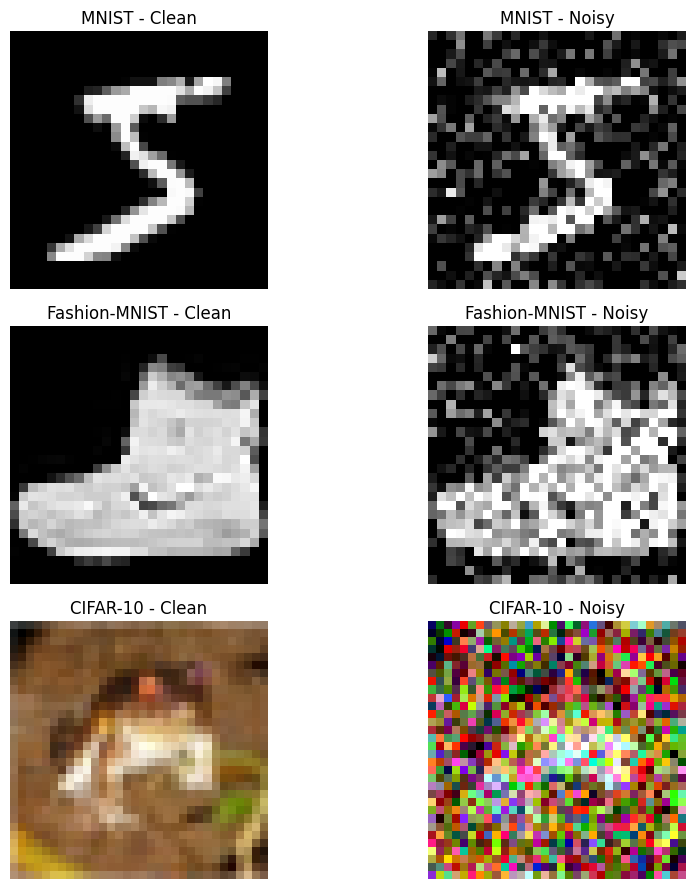


Processing MNIST dataset...
  Training mobilenet model...
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step


KeyboardInterrupt: 

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import pandas as pd
from tensorflow.keras.datasets import mnist, fashion_mnist, cifar10
from tensorflow.keras import Input, Model
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, NASNetMobile, DenseNet121

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

def add_noise(data, noise_factor=0.3):
    noisy = data + noise_factor * np.random.normal(0.0, 1.0, data.shape)
    return np.clip(noisy, 0., 1.)

def build_model(input_shape, model_type='mobilenet'):
    inputs = Input(shape=input_shape)

    # Preprocessing for all pretrained models
    # Add channels if needed (for grayscale images)
    if input_shape[-1] == 1:
        x = tf.keras.layers.Concatenate()([inputs, inputs, inputs])
    else:
        x = inputs

    # Special handling for DenseNet which needs larger images
    if model_type == 'densenet' and input_shape[0] < 32:
        x = tf.keras.layers.UpSampling2D(size=(64//input_shape[0], 64//input_shape[0]))(x)
    # For other models
    elif input_shape[0] < 32:
        x = tf.keras.layers.UpSampling2D(size=(32//input_shape[0], 32//input_shape[0]))(x)

    if model_type == 'mobilenet':
        # MobileNetV2 - lightweight and efficient
        base = MobileNetV2(weights=None, include_top=False, input_tensor=x)
        x = tf.keras.layers.GlobalAveragePooling2D()(base.output)
        outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
    elif model_type == 'efficientnet':
        # EfficientNetB0 - smallest in EfficientNet family
        base = EfficientNetB0(weights=None, include_top=False, input_tensor=x)
        x = tf.keras.layers.GlobalAveragePooling2D()(base.output)
        outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
    elif model_type == 'densenet':
        # DenseNet121 - needs larger input size
        base = DenseNet121(weights=None, include_top=False, input_tensor=x)
        x = tf.keras.layers.GlobalAveragePooling2D()(base.output)
        outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def plot_all_sample_images(datasets):
    fig, axes = plt.subplots(len(datasets), 2, figsize=(10, 3*len(datasets)))
    for i, (dataset, name) in enumerate(datasets):
        (x_train, _), _ = dataset.load_data()
        x_train = x_train / 255.0
        if x_train.ndim == 3:
            x_train = np.expand_dims(x_train, -1)
        x_train_noisy = add_noise(x_train)

        axes[i, 0].imshow(x_train[0].squeeze(), cmap='gray')
        axes[i, 0].set_title(f'{name} - Clean')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(x_train_noisy[0].squeeze(), cmap='gray')
        axes[i, 1].set_title(f'{name} - Noisy')
        axes[i, 1].axis('off')
    plt.tight_layout()
    plt.show()

def combined_tsne_visualization(all_models, all_x_test, all_y_test, dataset_names, model_types, condition):
    plt.figure(figsize=(20, 15))
    for i, (models, x_test, y_test, dataset_name) in enumerate(zip(all_models, all_x_test, all_y_test, dataset_names)):
        for j, (model, model_type) in enumerate(zip(models, model_types)):
            if model is None:
                continue
            plt.subplot(len(dataset_names), len(model_types), i*len(model_types) + j + 1)

            # Get the last layer before the output layer
            layer_output = model.layers[-2].output
            intermediate_layer_model = Model(inputs=model.input, outputs=layer_output)
            features = intermediate_layer_model.predict(x_test[:1000])
            tsne = TSNE(n_components=2, random_state=42)
            reduced = tsne.fit_transform(features)

            scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=y_test[:1000], cmap='tab10', s=10)
            plt.title(f"{dataset_name} - {model_type}")
            if j == 0:
                plt.ylabel(condition)
            if i == 0 and j == len(model_types)-1:
                plt.colorbar(scatter, ax=plt.gca())
            plt.grid(True)
    plt.suptitle(f"t-SNE Feature Visualization ({condition} Data)", y=1.02)
    plt.tight_layout()
    plt.show()

def combined_conf_matrices(all_y_test, all_preds, dataset_names, model_types, condition):
    plt.figure(figsize=(20, 15))
    for i, (y_test, preds, dataset_name) in enumerate(zip(all_y_test, all_preds, dataset_names)):
        for j, (pred, model_type) in enumerate(zip(preds, model_types)):
            if pred is None:
                continue
            plt.subplot(len(dataset_names), len(model_types), i*len(model_types) + j + 1)
            cm = confusion_matrix(y_test, pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot(cmap='Blues', ax=plt.gca())
            plt.title(f"{dataset_name} - {model_type}")
            if j == 0:
                plt.ylabel(condition)
    plt.suptitle(f"Confusion Matrices ({condition} Data)", y=1.02)
    plt.tight_layout()
    plt.show()

def combined_roc_curves(all_models, all_x_test, all_y_test, dataset_names, model_types, condition):
    plt.figure(figsize=(20, 15))
    for i, (models, x_test, y_test, dataset_name) in enumerate(zip(all_models, all_x_test, all_y_test, dataset_names)):
        for j, (model, model_type) in enumerate(zip(models, model_types)):
            if model is None:
                continue
            plt.subplot(len(dataset_names), len(model_types), i*len(model_types) + j + 1)

            y_score = model.predict(x_test)
            y_bin = label_binarize(y_test, classes=list(range(10)))
            fpr, tpr, _ = roc_curve(y_bin.ravel(), y_score.ravel())
            roc_auc = auc(fpr, tpr)

            plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f"{dataset_name} - {model_type}")
            plt.legend(loc='lower right')
            if j == 0:
                plt.ylabel(condition)
            plt.grid(True)
    plt.suptitle(f"ROC Curves ({condition} Data)", y=1.02)
    plt.tight_layout()
    plt.show()

def combined_training_curves(all_histories, dataset_names, model_types, condition):
    plt.figure(figsize=(20, 15))
    for i, (histories, dataset_name) in enumerate(zip(all_histories, dataset_names)):
        for j, (history, model_type) in enumerate(zip(histories, model_types)):
            if history is None:
                continue
            plt.subplot(len(dataset_names), len(model_types), i*len(model_types) + j + 1)

            # Plot training and validation loss
            plt.plot(history.history['loss'], label='Train Loss', color='blue')
            plt.plot(history.history['val_loss'], label='Val Loss', color='orange')

            # Plot training and validation accuracy on secondary axis
            ax2 = plt.gca().twinx()
            ax2.plot(history.history['accuracy'], label='Train Acc', color='green', linestyle='--')
            ax2.plot(history.history['val_accuracy'], label='Val Acc', color='red', linestyle='--')

            plt.title(f"{dataset_name} - {model_type}")
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            ax2.set_ylabel('Accuracy')
            if j == 0:
                plt.ylabel(condition)
            plt.grid(True)

            # Combine legends
            lines, labels = plt.gca().get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            plt.legend(lines + lines2, labels + labels2, loc='upper right')

    plt.suptitle(f"Training Curves ({condition} Data)", y=1.02)
    plt.tight_layout()
    plt.show()

def plot_performance_summary(df):
    plt.figure(figsize=(18, 8))

    # Melt the dataframe for seaborn
    df_melted = df.melt(id_vars=['Dataset', 'Model'],
                        value_vars=['Clean Accuracy (%)', 'Noisy Accuracy (%)'],
                        var_name='Condition', value_name='Accuracy')

    # Clean vs Noisy comparison
    plt.subplot(1, 2, 1)
    sns.barplot(x='Dataset', y='Accuracy', hue='Condition', data=df_melted)
    plt.title("Clean vs Noisy Accuracy Comparison")
    plt.ylabel("Accuracy (%)")
    plt.grid(True)
    plt.xticks(rotation=0)

    # Model performance across datasets
    plt.subplot(1, 2, 2)
    sns.barplot(x='Dataset', y='Accuracy', hue='Model',
                data=df_melted, ci=None, palette='viridis')
    plt.title("Model Performance Across Datasets")
    plt.ylabel("Accuracy (%)")
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

def process_datasets(datasets):
    all_results = []
    all_clean_models = []
    all_noisy_models = []
    all_x_test = []
    all_y_test = []
    all_x_test_noisy = []
    all_clean_preds = []
    all_noisy_preds = []
    all_clean_histories = []
    all_noisy_histories = []
    dataset_names = []

    model_types = ['mobilenet', 'efficientnet', 'densenet']

    for loader, name in datasets:
        print(f"\nProcessing {name} dataset...")
        (x_train, y_train), (x_test, y_test) = loader.load_data()
        x_train, x_test = x_train / 255.0, x_test / 255.0

        if x_train.ndim == 3:
            x_train = np.expand_dims(x_train, -1)
            x_test = np.expand_dims(x_test, -1)

        input_shape = x_train.shape[1:]
        x_train_noisy = add_noise(x_train)
        x_test_noisy = add_noise(x_test)

        clean_models = []
        noisy_models = []
        clean_preds = []
        noisy_preds = []
        clean_histories = []
        noisy_histories = []

        for model_type in model_types:
            print(f"  Training {model_type} model...")
            try:
                # Clean Model
                model_clean = build_model(input_shape, model_type)
                history_clean = model_clean.fit(x_train, y_train, epochs=2,
                                              validation_data=(x_test, y_test), verbose=0)
                clean_pred = np.argmax(model_clean.predict(x_test), axis=1)

                # Noisy Model
                model_noisy = build_model(input_shape, model_type)
                history_noisy = model_noisy.fit(x_train_noisy, y_train, epochs=2,
                                              validation_data=(x_test_noisy, y_test), verbose=0)
                noisy_pred = np.argmax(model_noisy.predict(x_test_noisy), axis=1)

                # Evaluate
                clean_loss, clean_acc = model_clean.evaluate(x_test, y_test, verbose=0)
                noisy_loss, noisy_acc = model_noisy.evaluate(x_test_noisy, y_test, verbose=0)

                clean_models.append(model_clean)
                noisy_models.append(model_noisy)
                clean_preds.append(clean_pred)
                noisy_preds.append(noisy_pred)
                clean_histories.append(history_clean)
                noisy_histories.append(history_noisy)

                all_results.append({
                    'Dataset': name,
                    'Model': model_type,
                    'Clean Accuracy (%)': round(clean_acc * 100, 2),
                    'Noisy Accuracy (%)': round(noisy_acc * 100, 2)
                })

            except Exception as e:
                print(f"Error with {model_type} on {name}: {str(e)}")
                clean_models.append(None)
                noisy_models.append(None)
                clean_preds.append(None)
                noisy_preds.append(None)
                clean_histories.append(None)
                noisy_histories.append(None)
                all_results.append({
                    'Dataset': name,
                    'Model': model_type,
                    'Clean Accuracy (%)': None,
                    'Noisy Accuracy (%)': None
                })
                continue

        all_clean_models.append(clean_models)
        all_noisy_models.append(noisy_models)
        all_x_test.append(x_test)
        all_y_test.append(y_test)
        all_x_test_noisy.append(x_test_noisy)
        all_clean_preds.append(clean_preds)
        all_noisy_preds.append(noisy_preds)
        all_clean_histories.append(clean_histories)
        all_noisy_histories.append(noisy_histories)
        dataset_names.append(name)

    return (all_results, all_clean_models, all_noisy_models, all_x_test, all_y_test,
            all_x_test_noisy, all_clean_preds, all_noisy_preds, all_clean_histories,
            all_noisy_histories, dataset_names, model_types)

# Define datasets to process
datasets = [
    (mnist, "MNIST"),
    (fashion_mnist, "Fashion-MNIST"),
    (cifar10, "CIFAR-10")
]

# Plot sample images for all datasets
plot_all_sample_images(datasets)

# Process all datasets
(all_results, all_clean_models, all_noisy_models, all_x_test, all_y_test,
 all_x_test_noisy, all_clean_preds, all_noisy_preds, all_clean_histories,
 all_noisy_histories, dataset_names, model_types) = process_datasets(datasets)

# Create Dataframe
df = pd.DataFrame(all_results)
print("\nPerformance Summary:")
print(df)

# Combined visualizations
combined_tsne_visualization(all_clean_models, all_x_test, all_y_test, dataset_names, model_types, "Clean")
combined_tsne_visualization(all_noisy_models, all_x_test_noisy, all_y_test, dataset_names, model_types, "Noisy")

combined_conf_matrices(all_y_test, all_clean_preds, dataset_names, model_types, "Clean")
combined_conf_matrices(all_y_test, all_noisy_preds, dataset_names, model_types, "Noisy")

combined_roc_curves(all_clean_models, all_x_test, all_y_test, dataset_names, model_types, "Clean")
combined_roc_curves(all_noisy_models, all_x_test_noisy, all_y_test, dataset_names, model_types, "Noisy")

# Training curves visualization
combined_training_curves(all_clean_histories, dataset_names, model_types, "Clean")
combined_training_curves(all_noisy_histories, dataset_names, model_types, "Noisy")

# Performance summary
plot_performance_summary(df)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


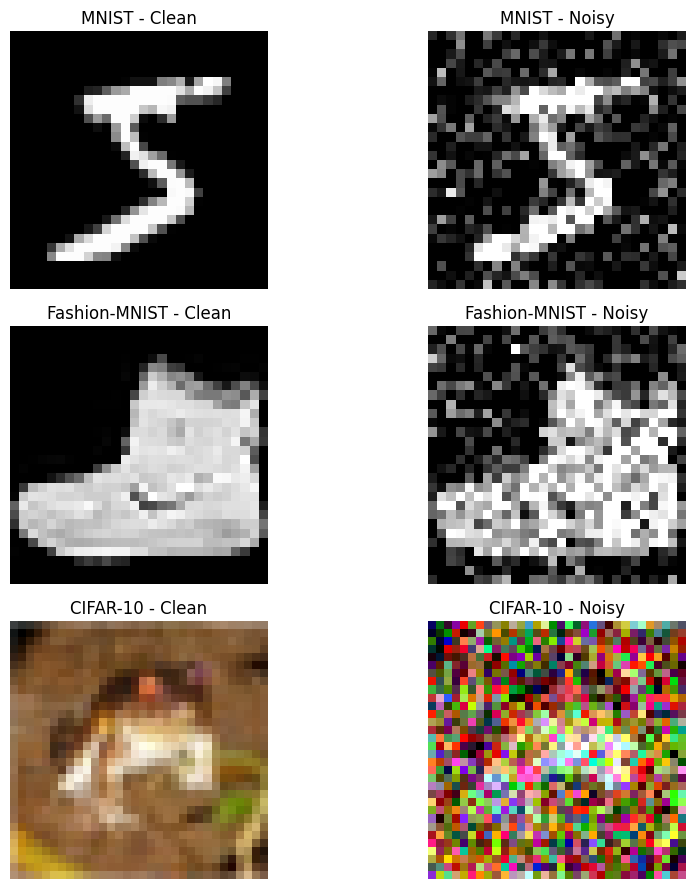


Processing MNIST dataset...
  Training mobilenet model...
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step
  Training efficientnet model...
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step
  Training densenet model...
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 40ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step

Processing Fashion-MNIST dataset...
  Training mobilenet model...
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step
  Training efficientnet model...
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step
  Training densenet model...
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step

Processing CIFAR-10 dataset...
  Training mobilenet model...
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step
  Training efficientnet model...
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step
313/313 ━━━━━━━━

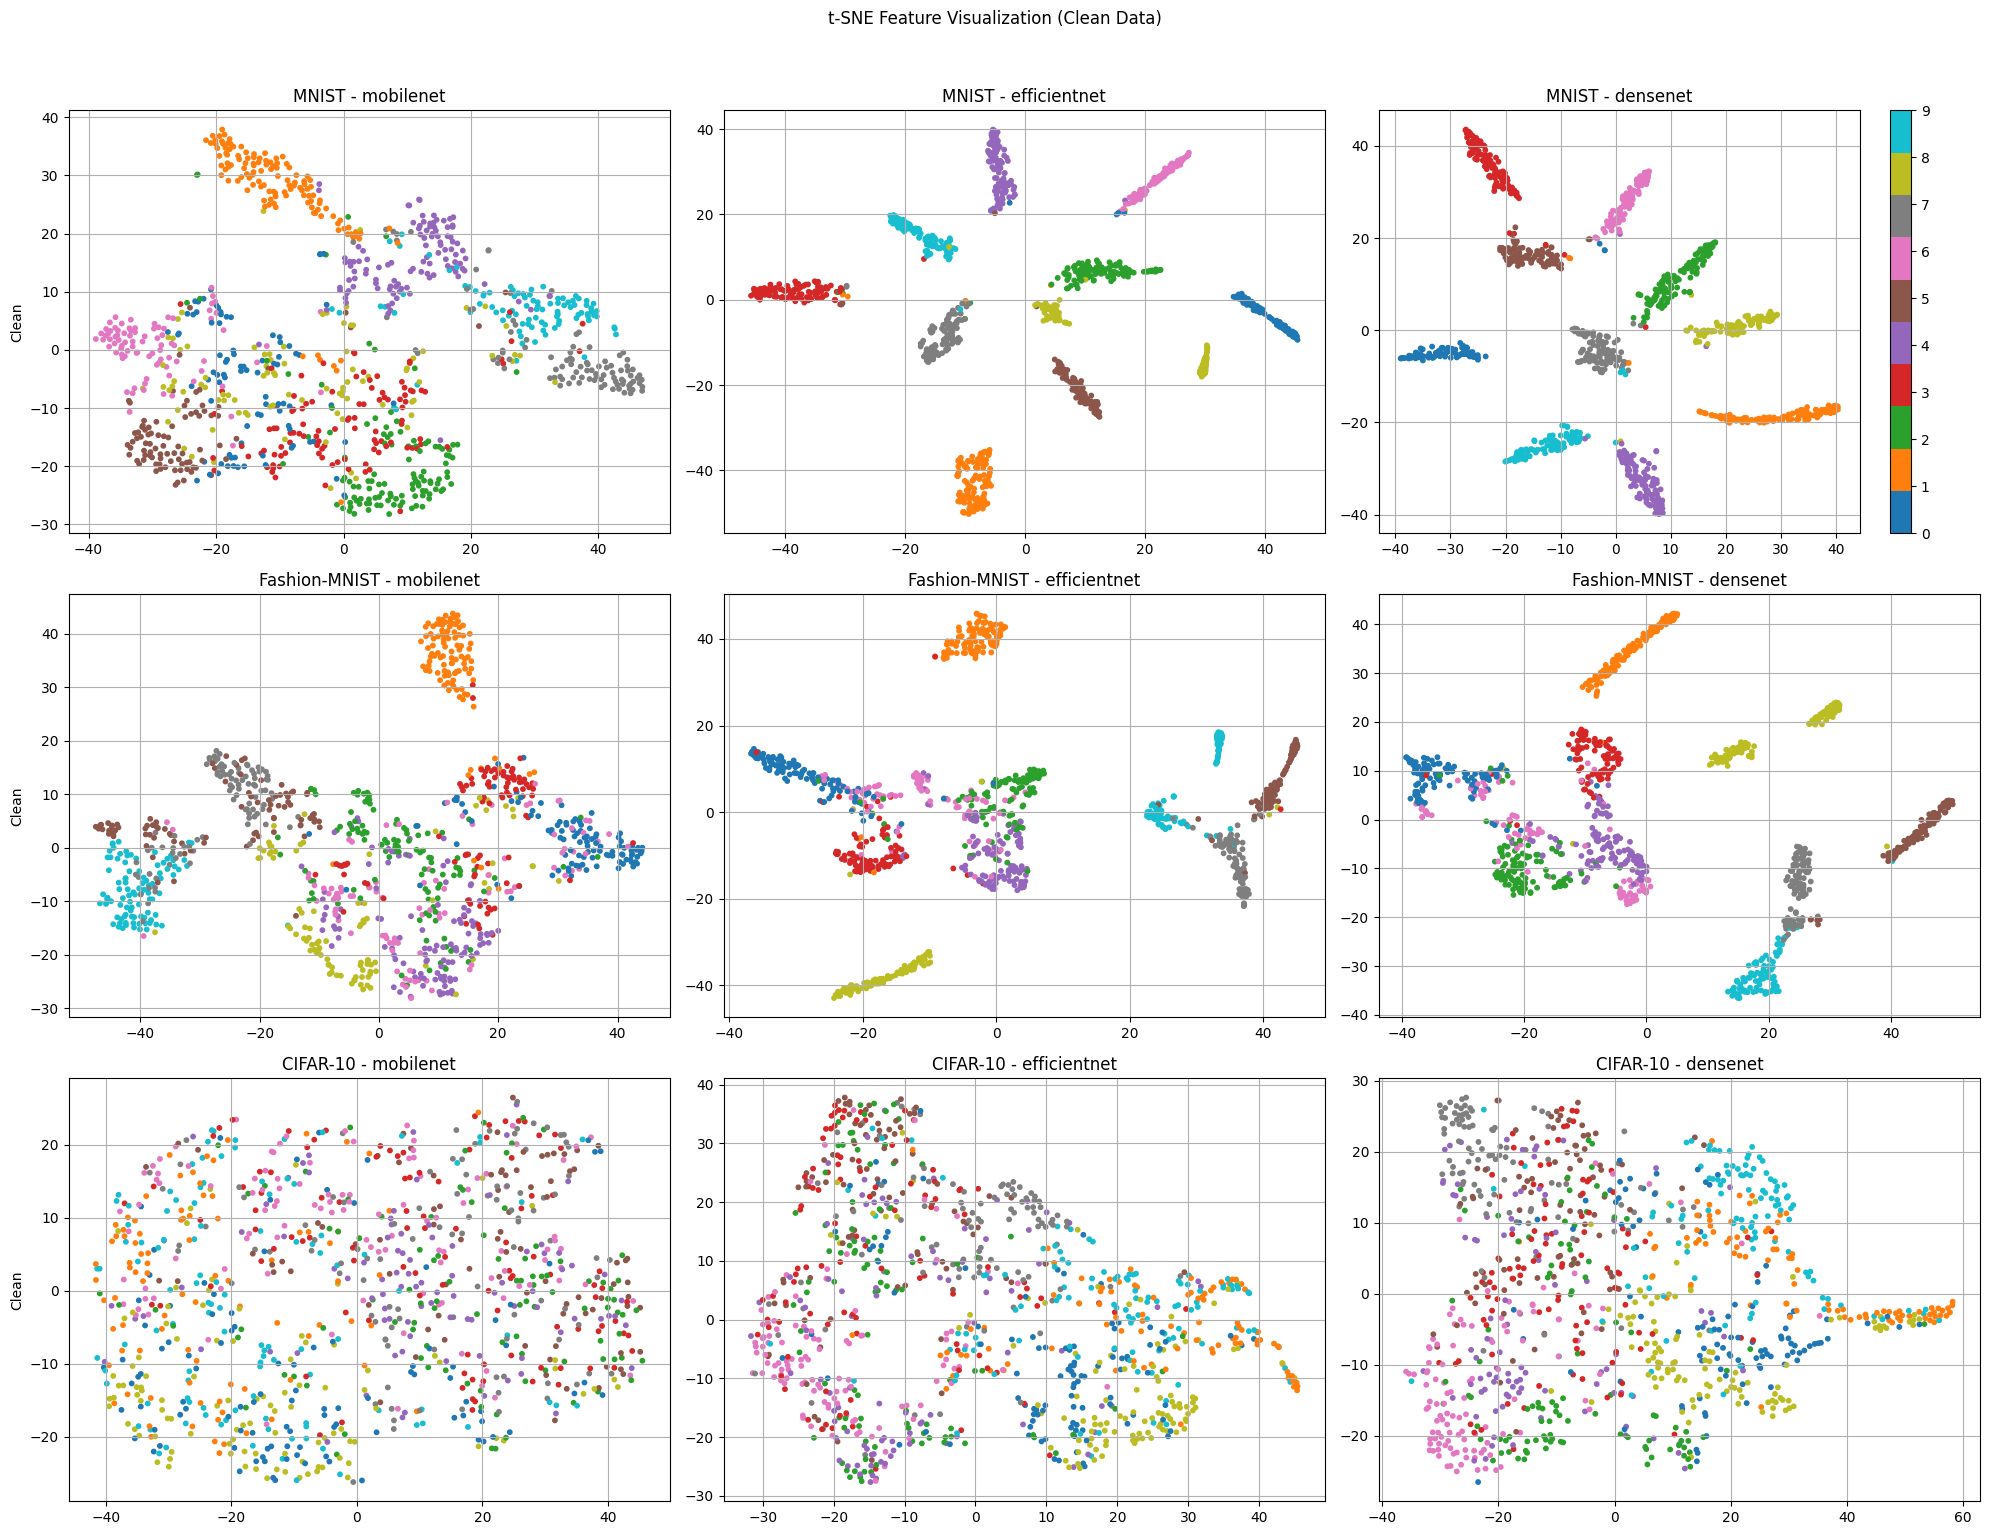

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 288ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 283ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 280ms/step


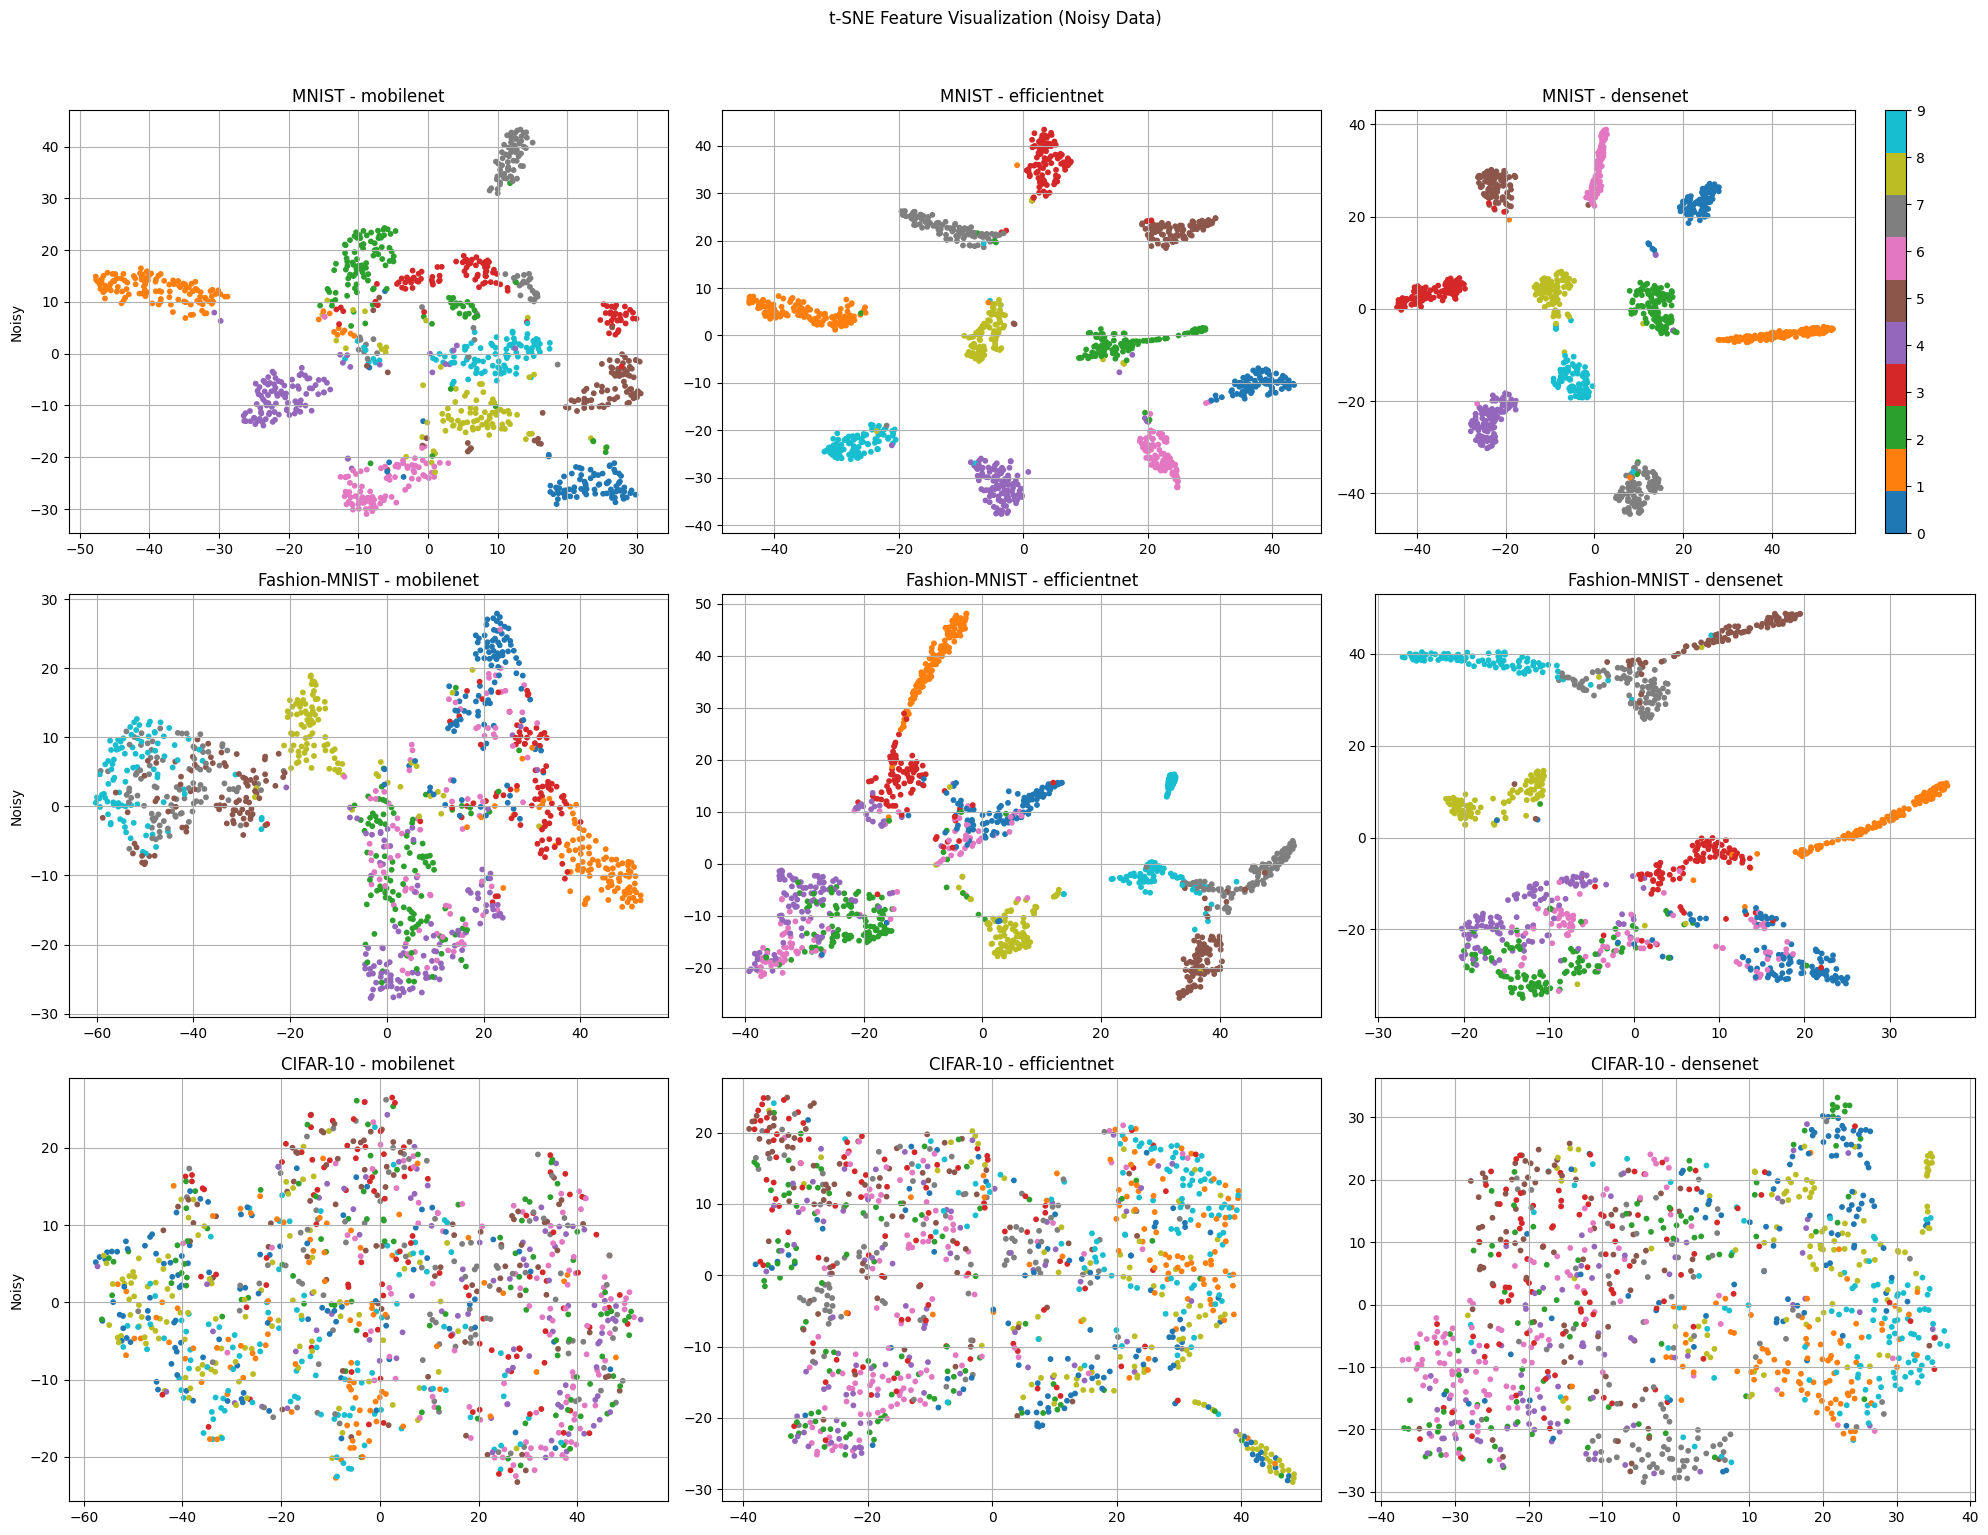

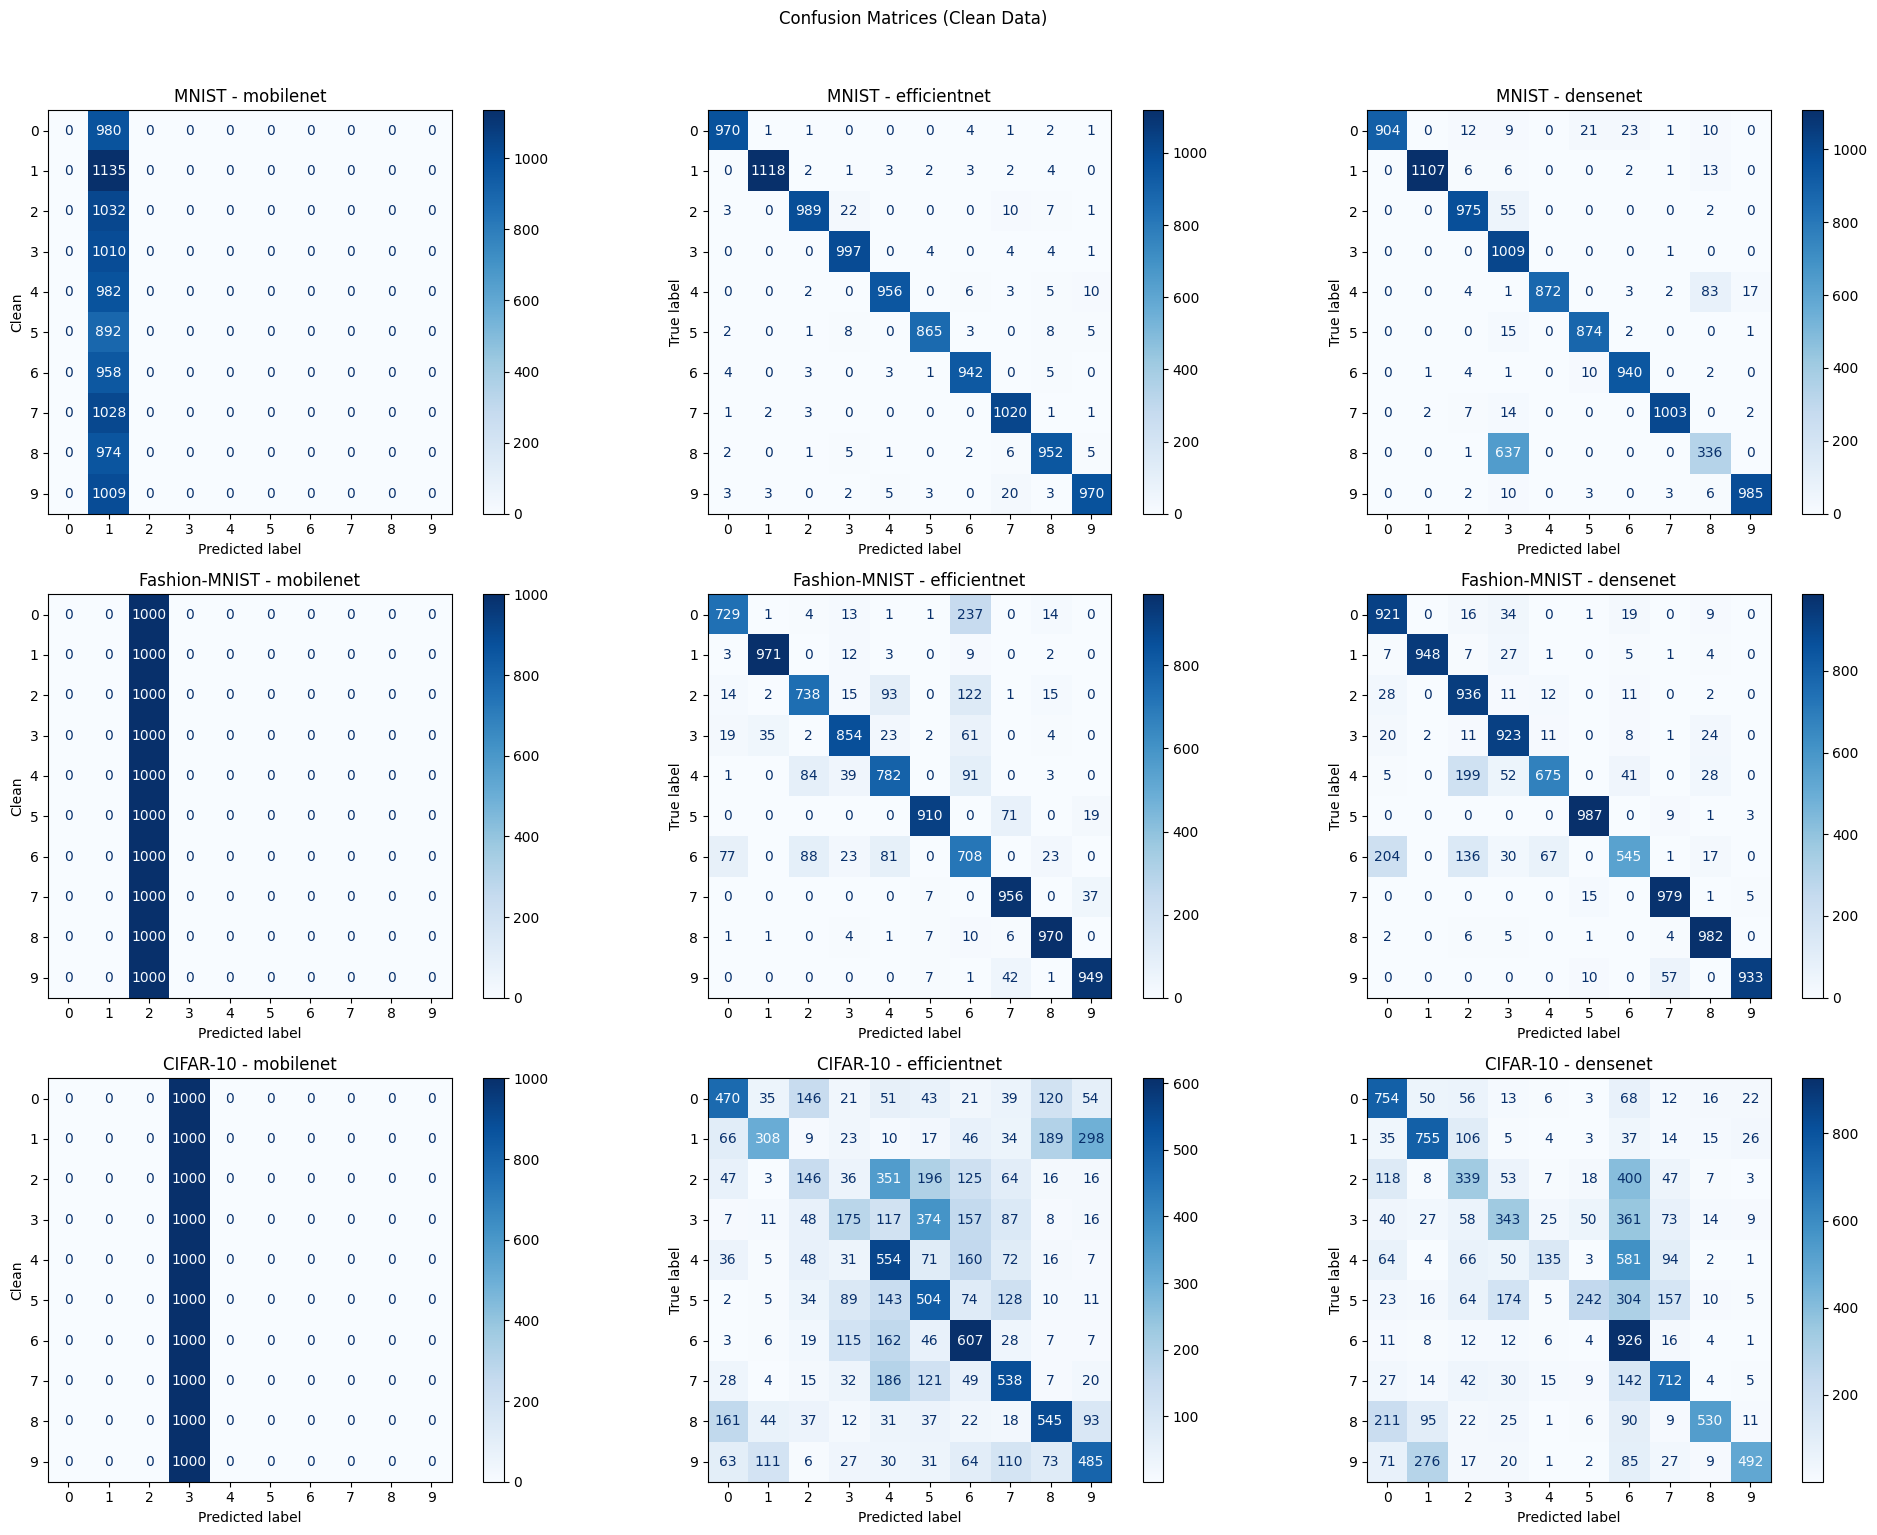

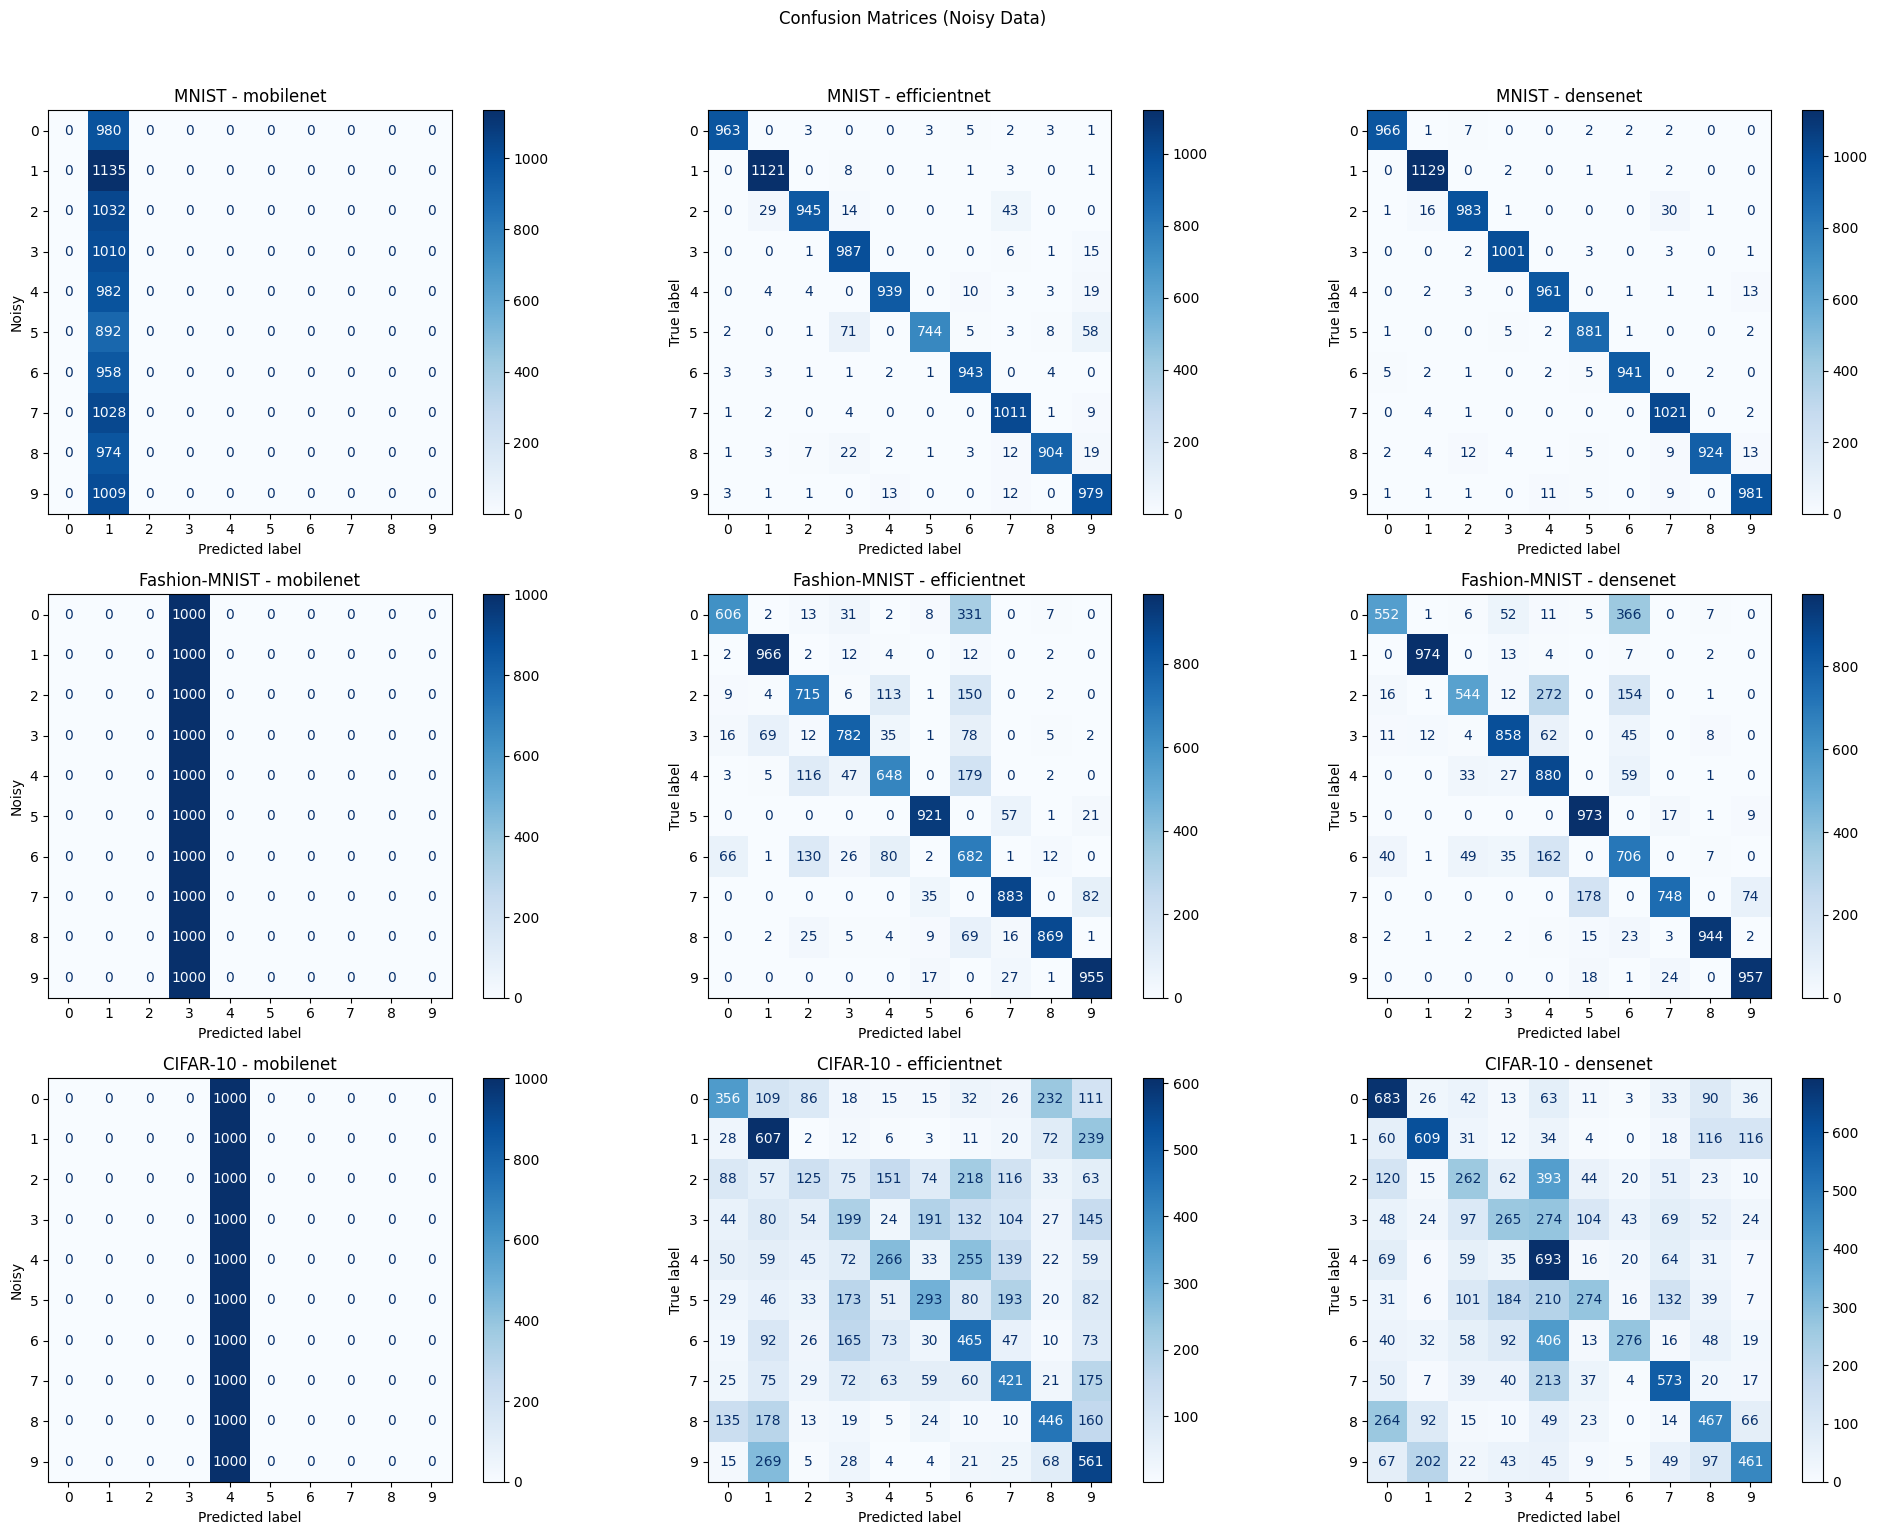

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


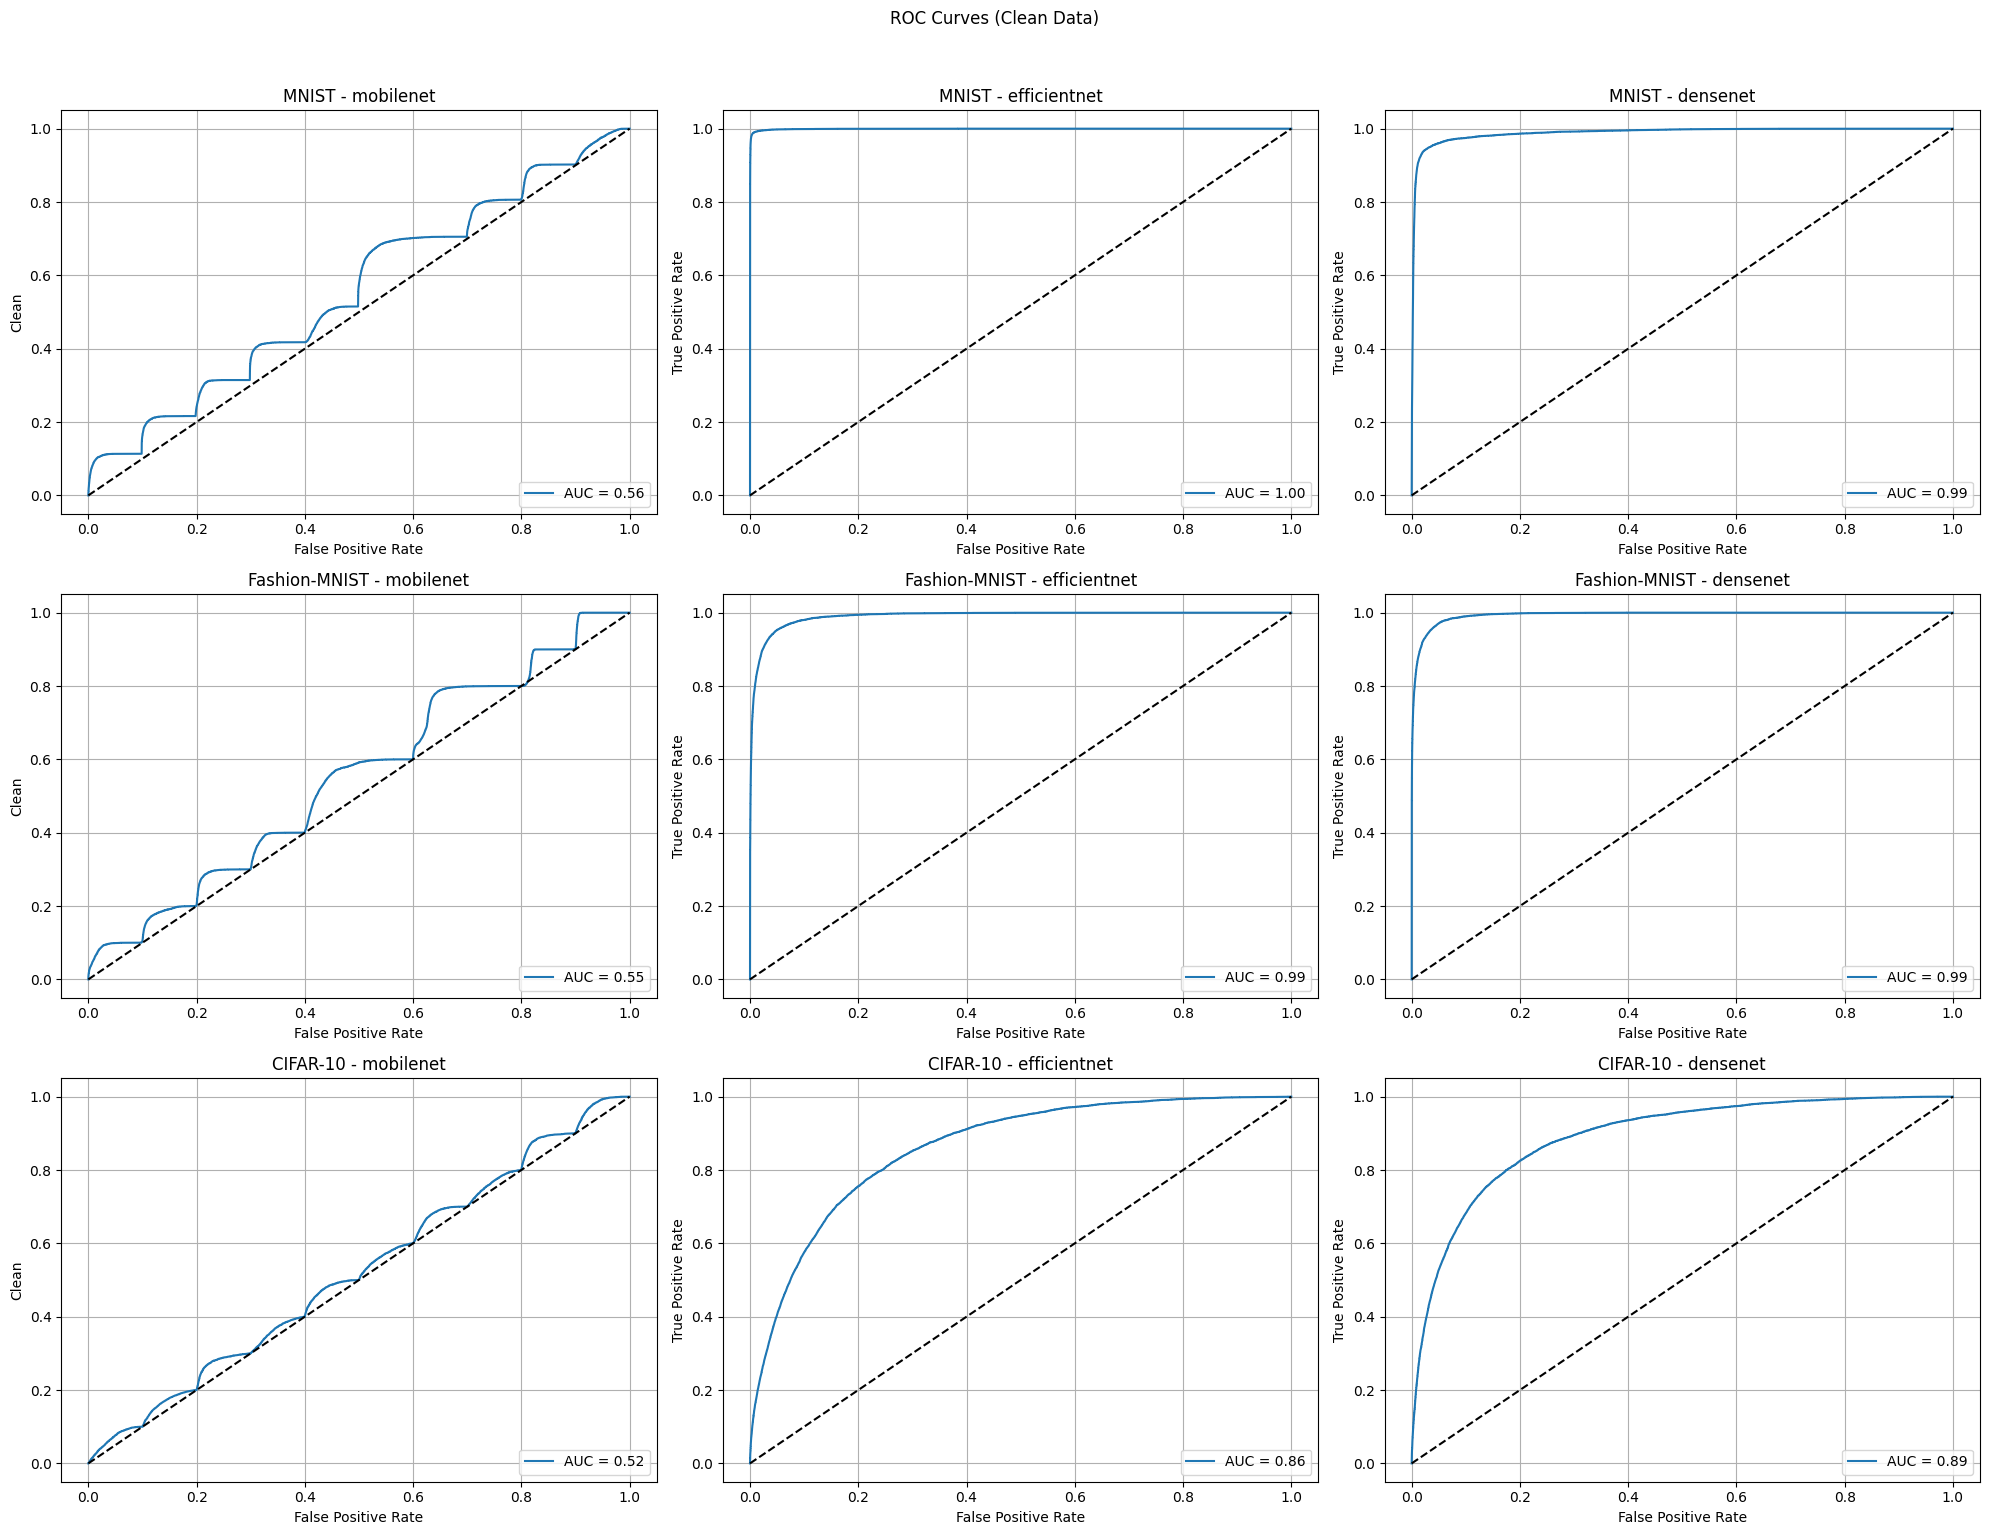

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


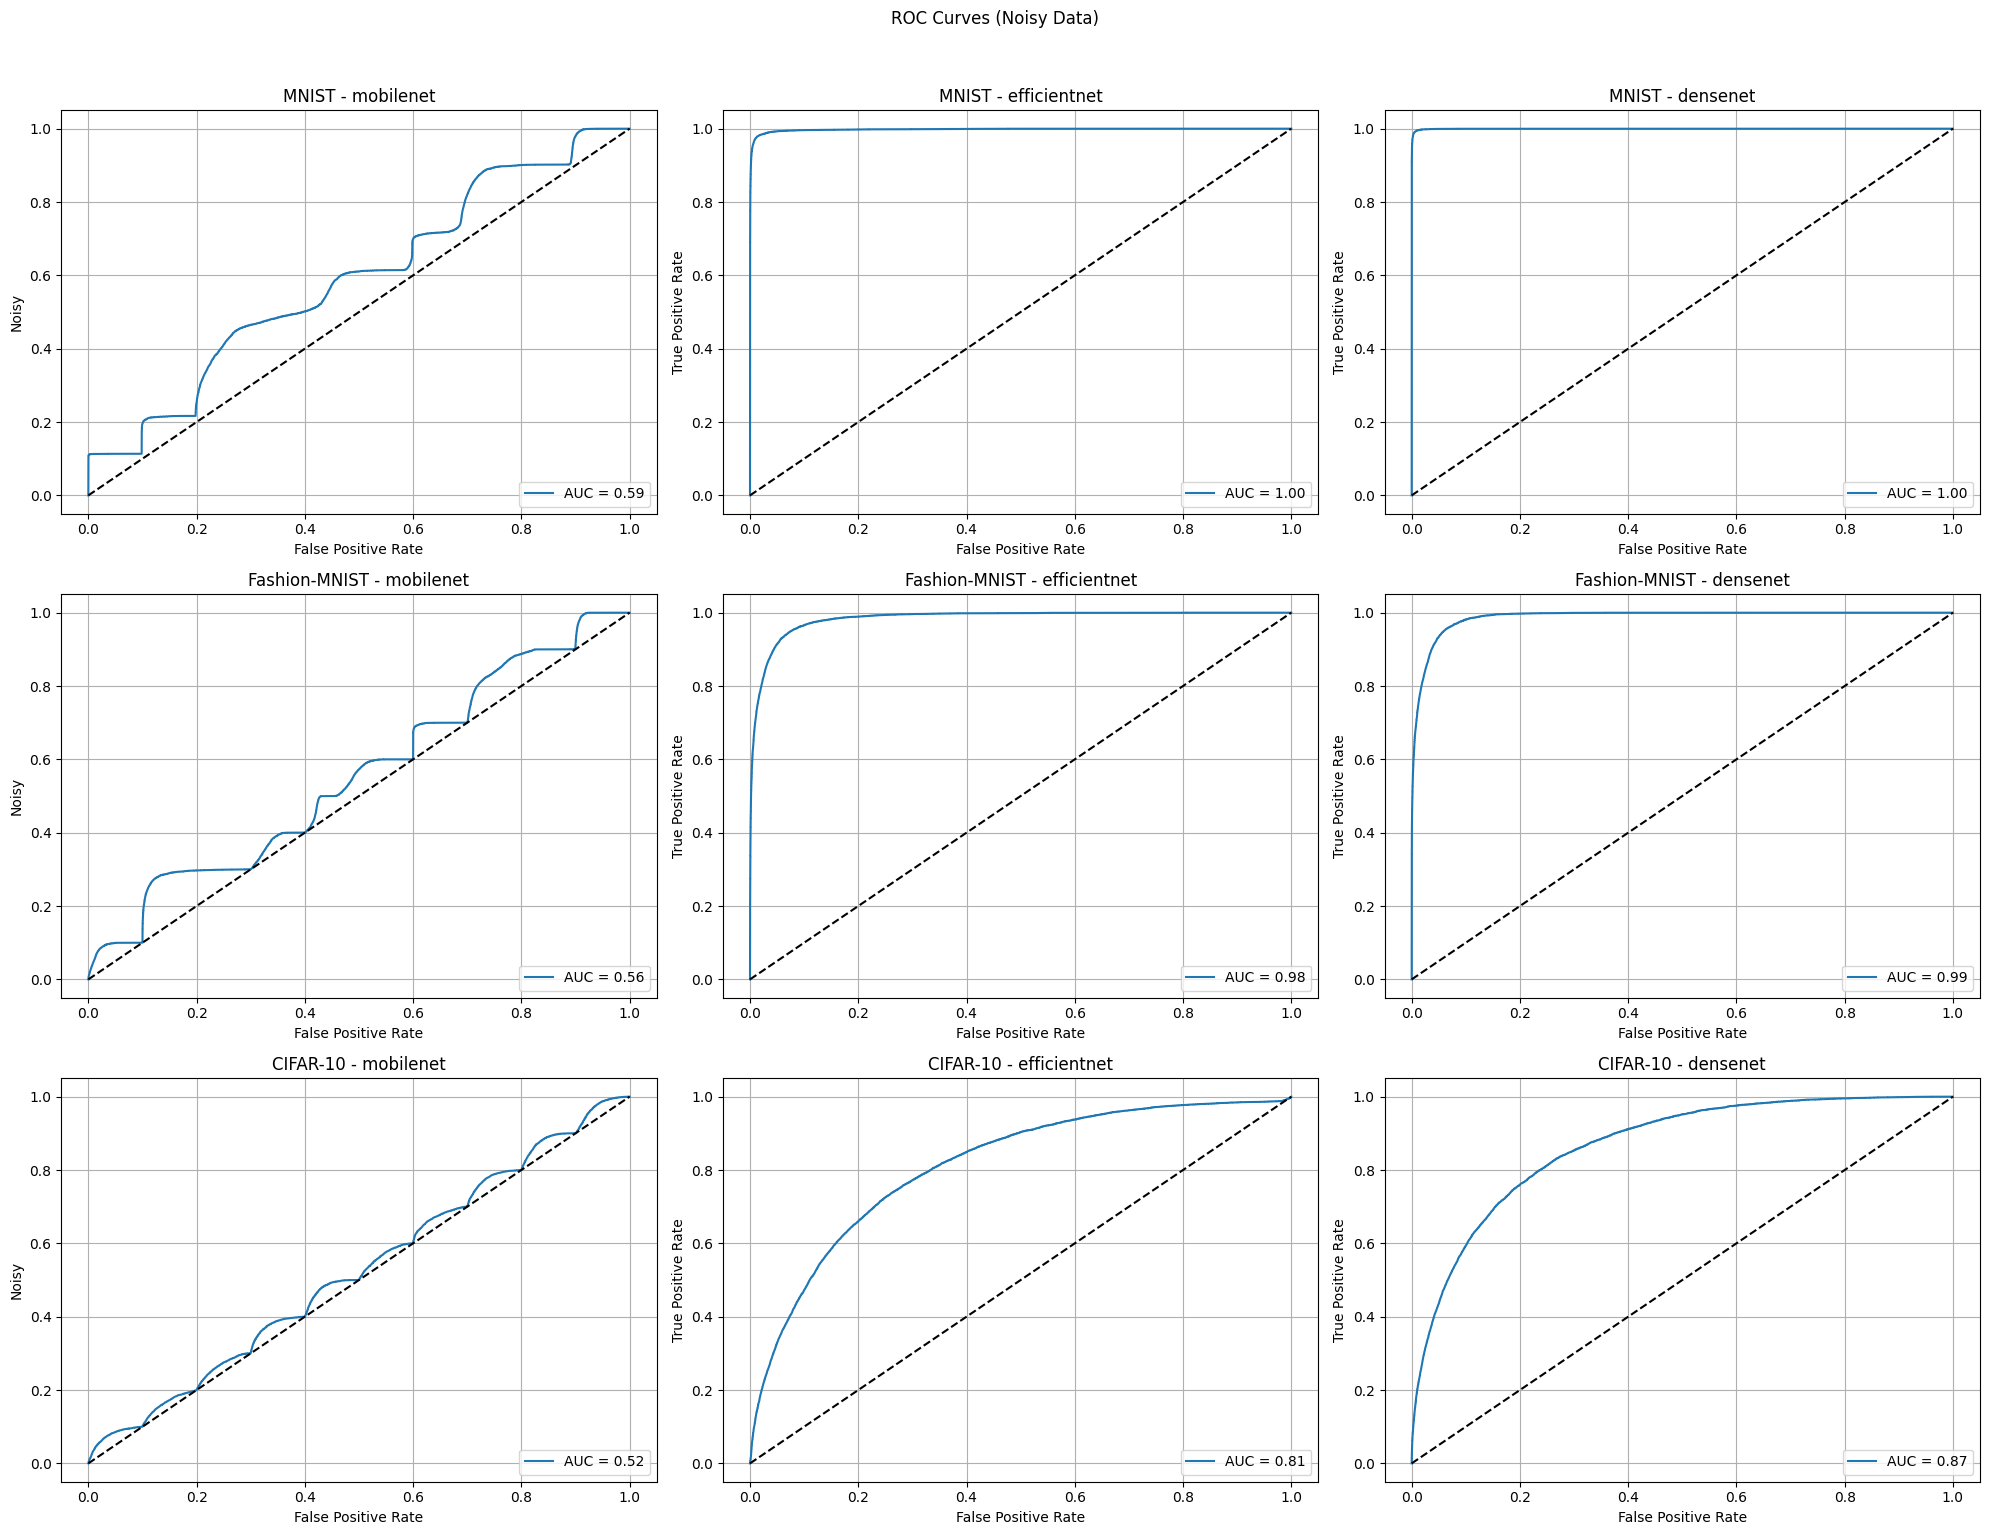

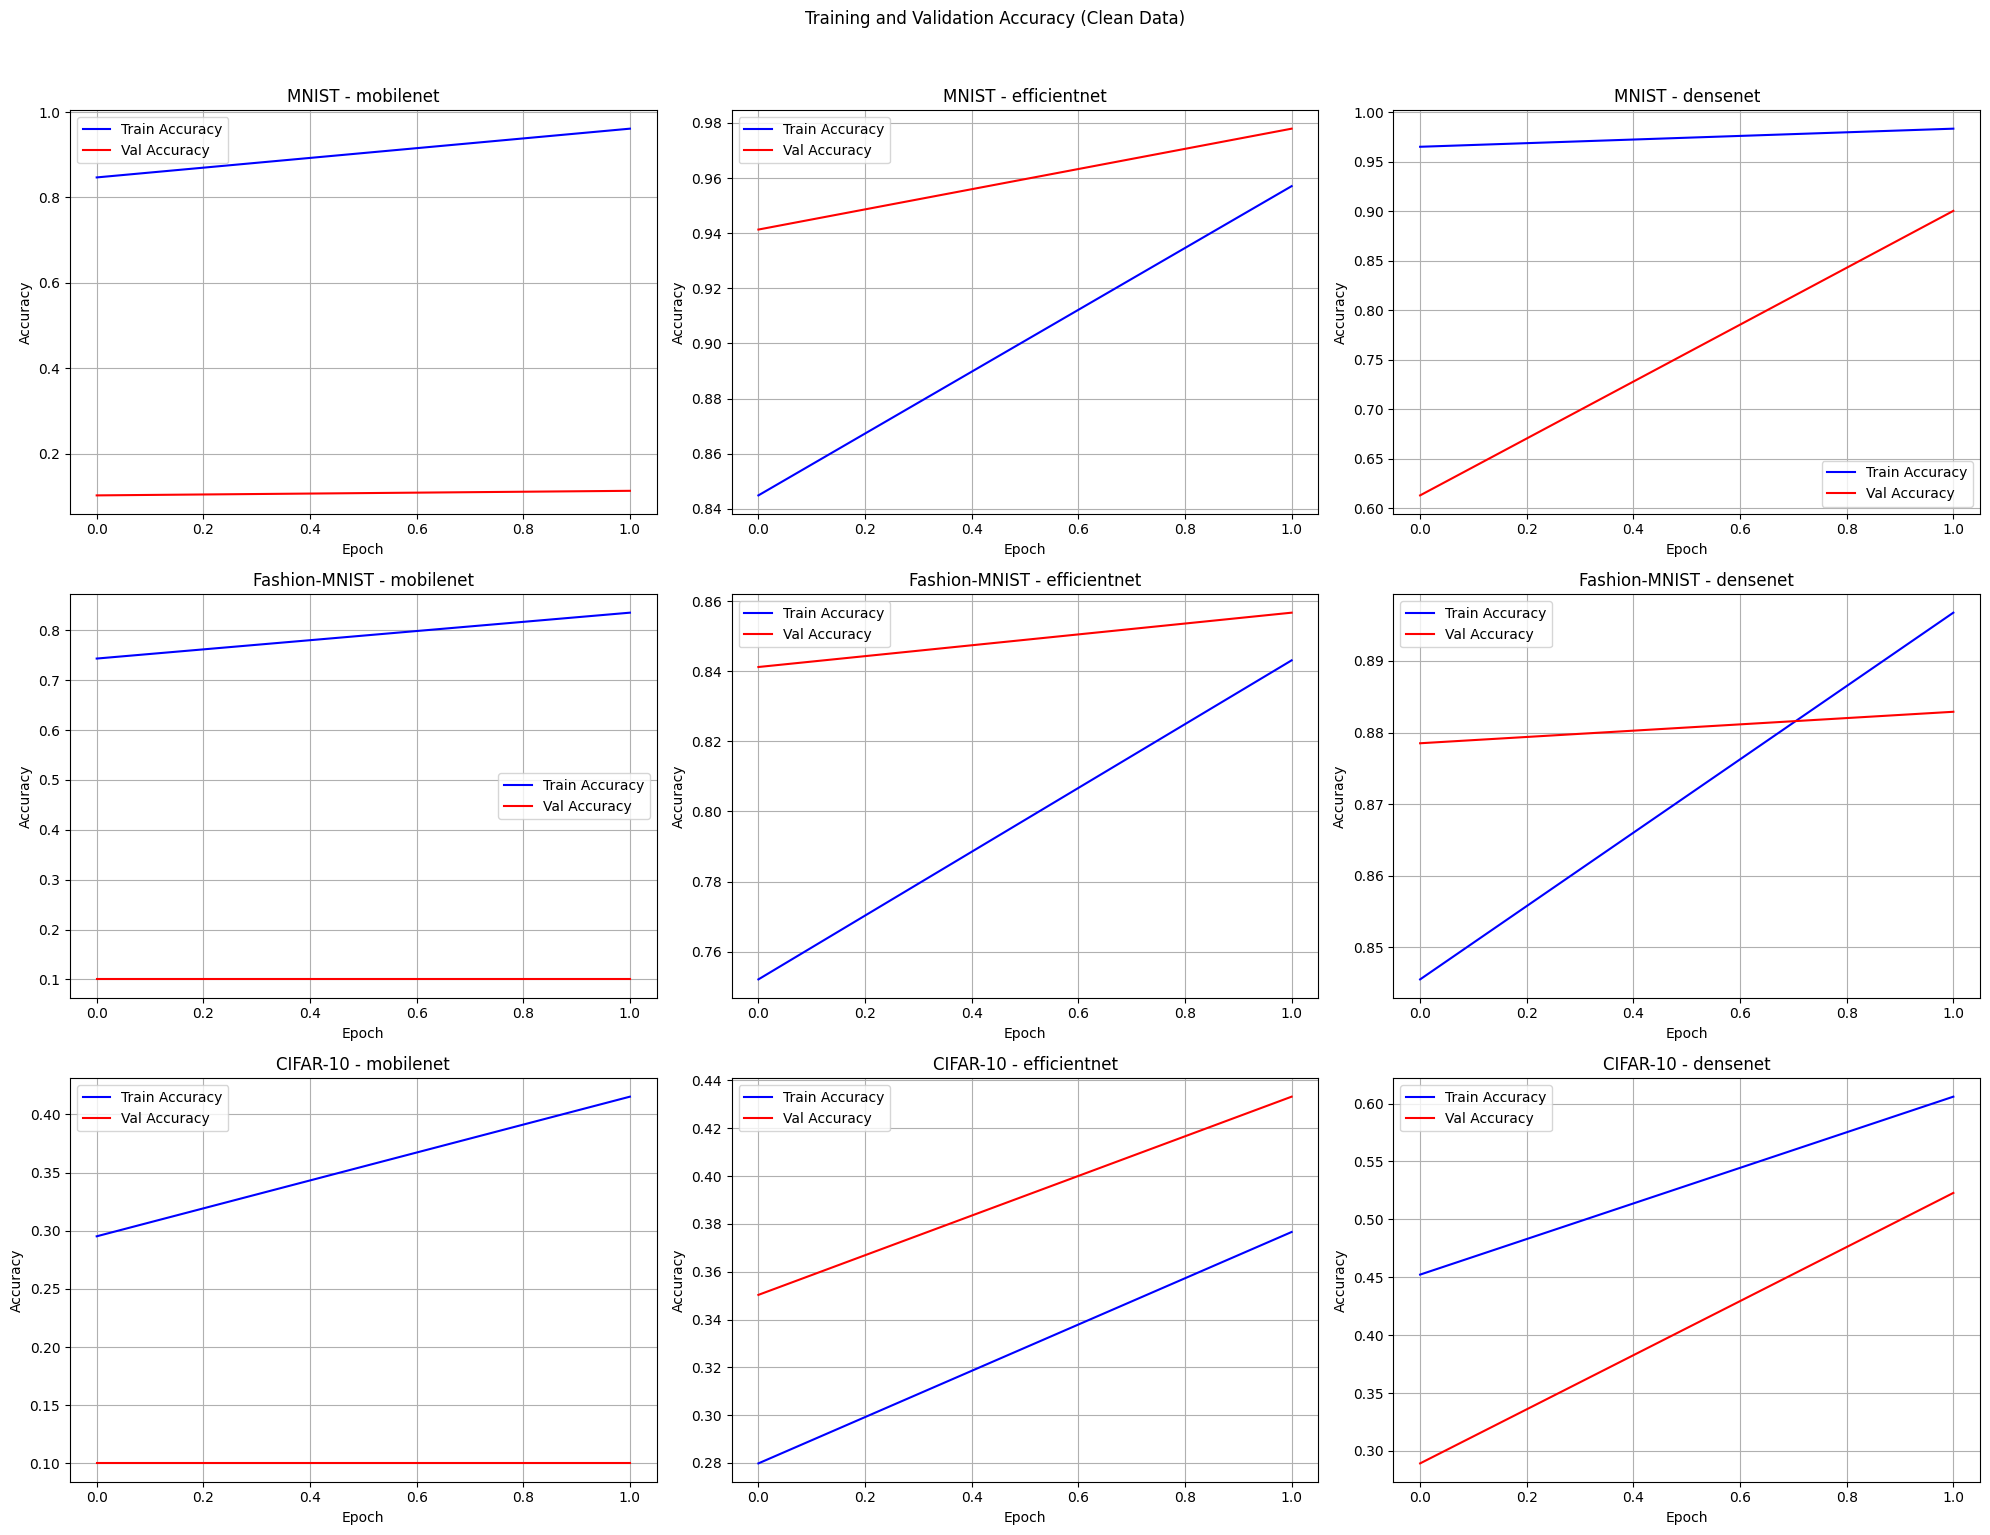

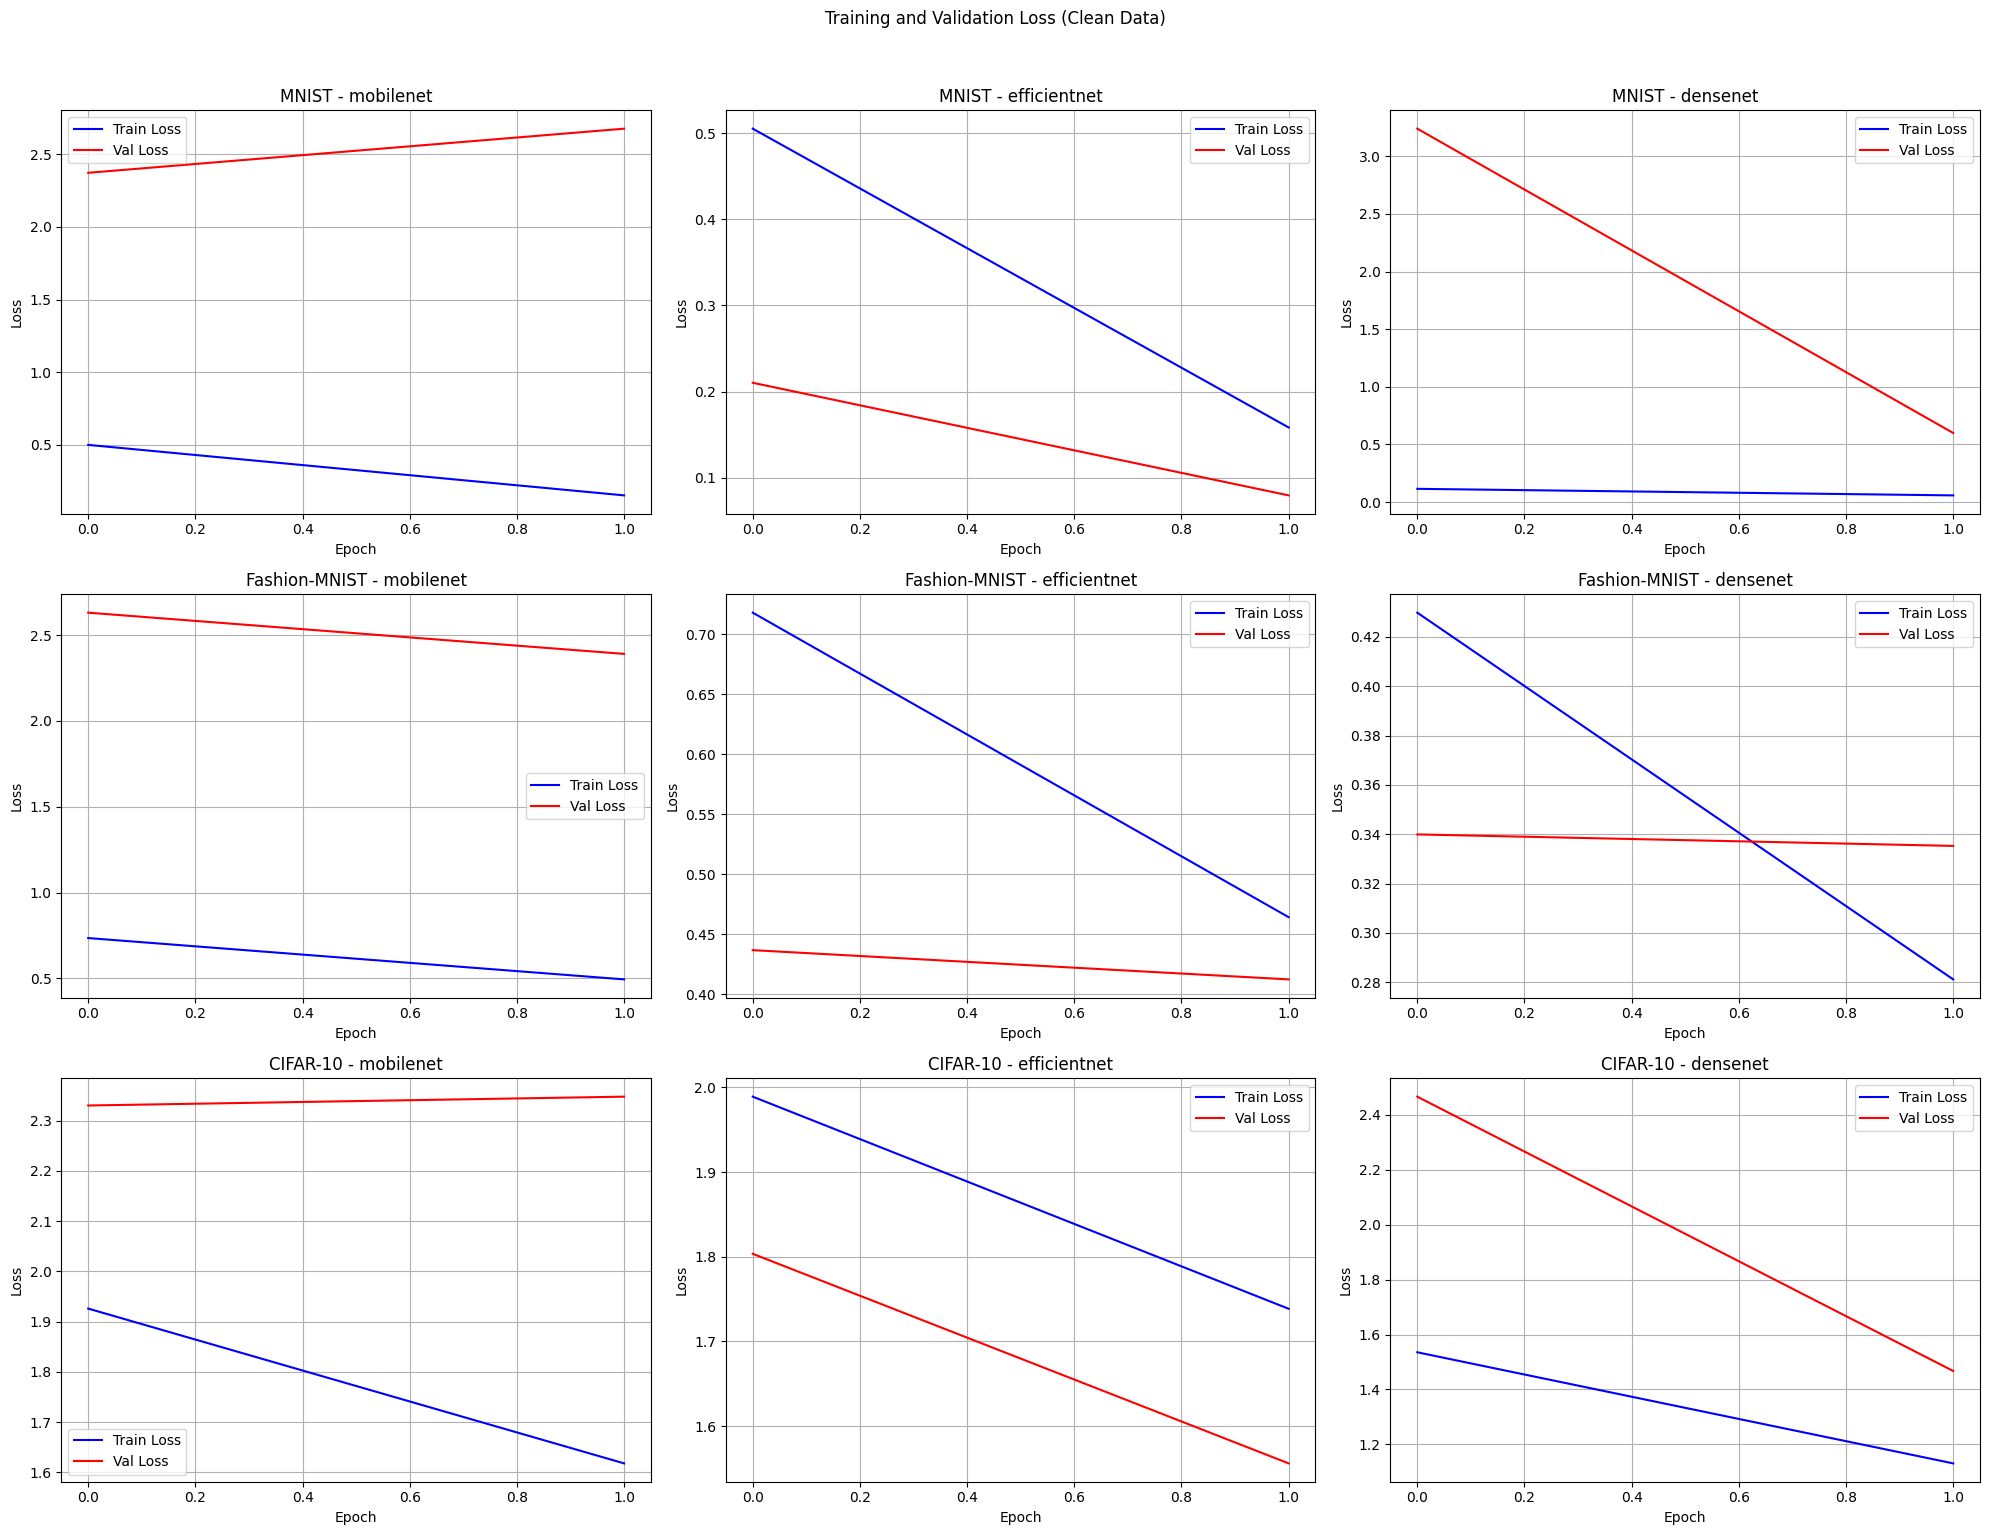

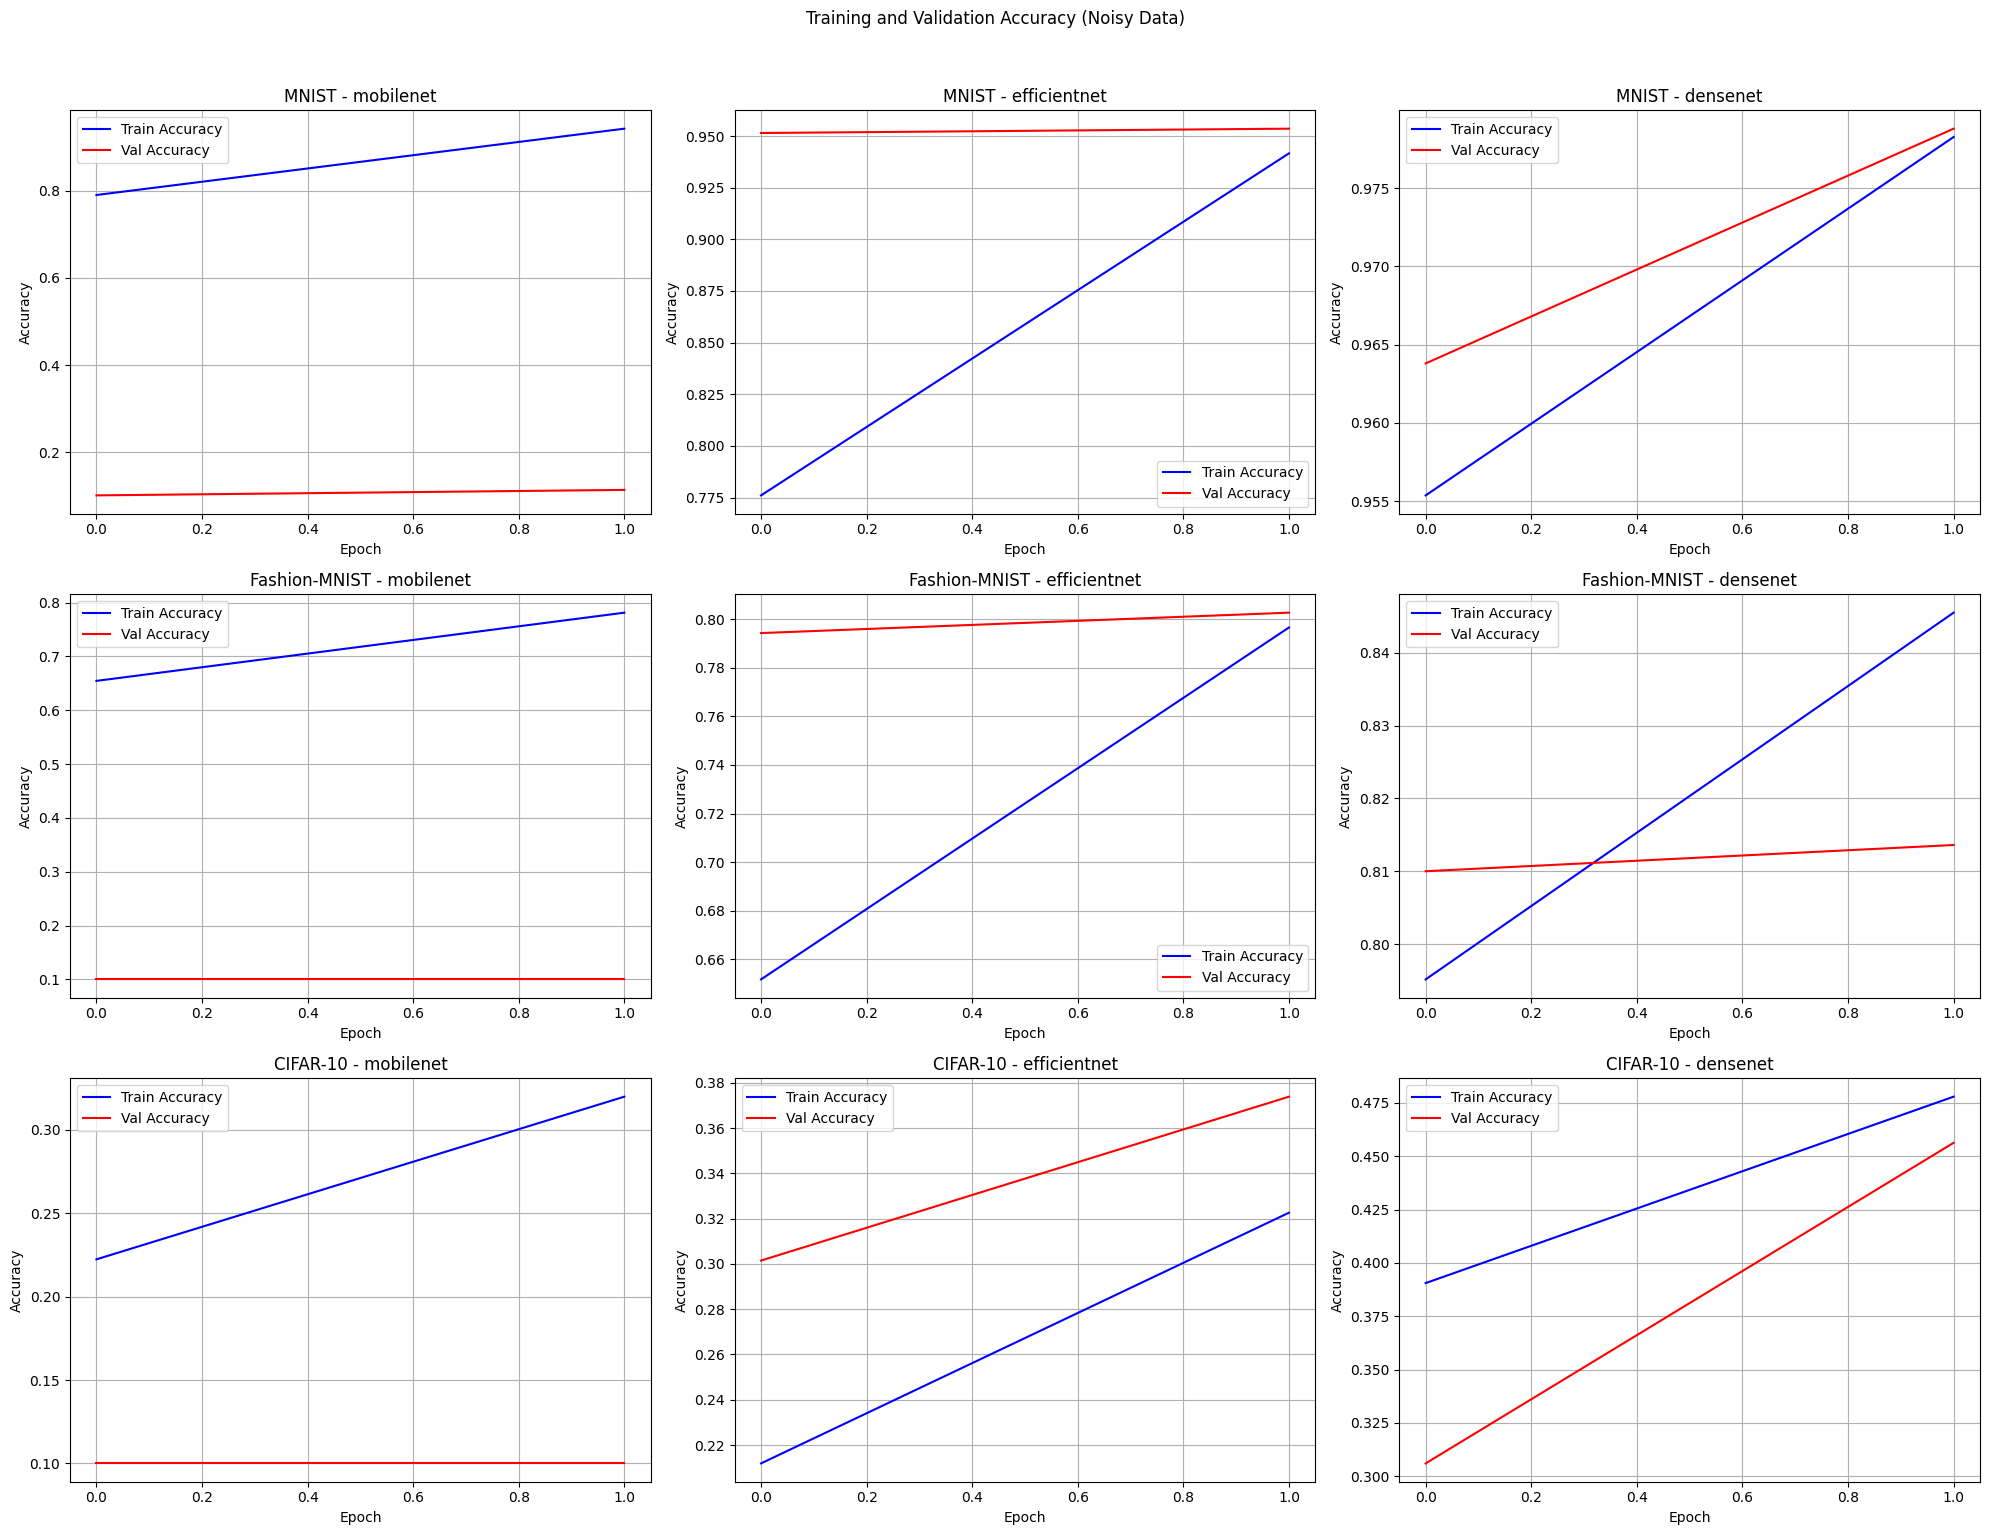

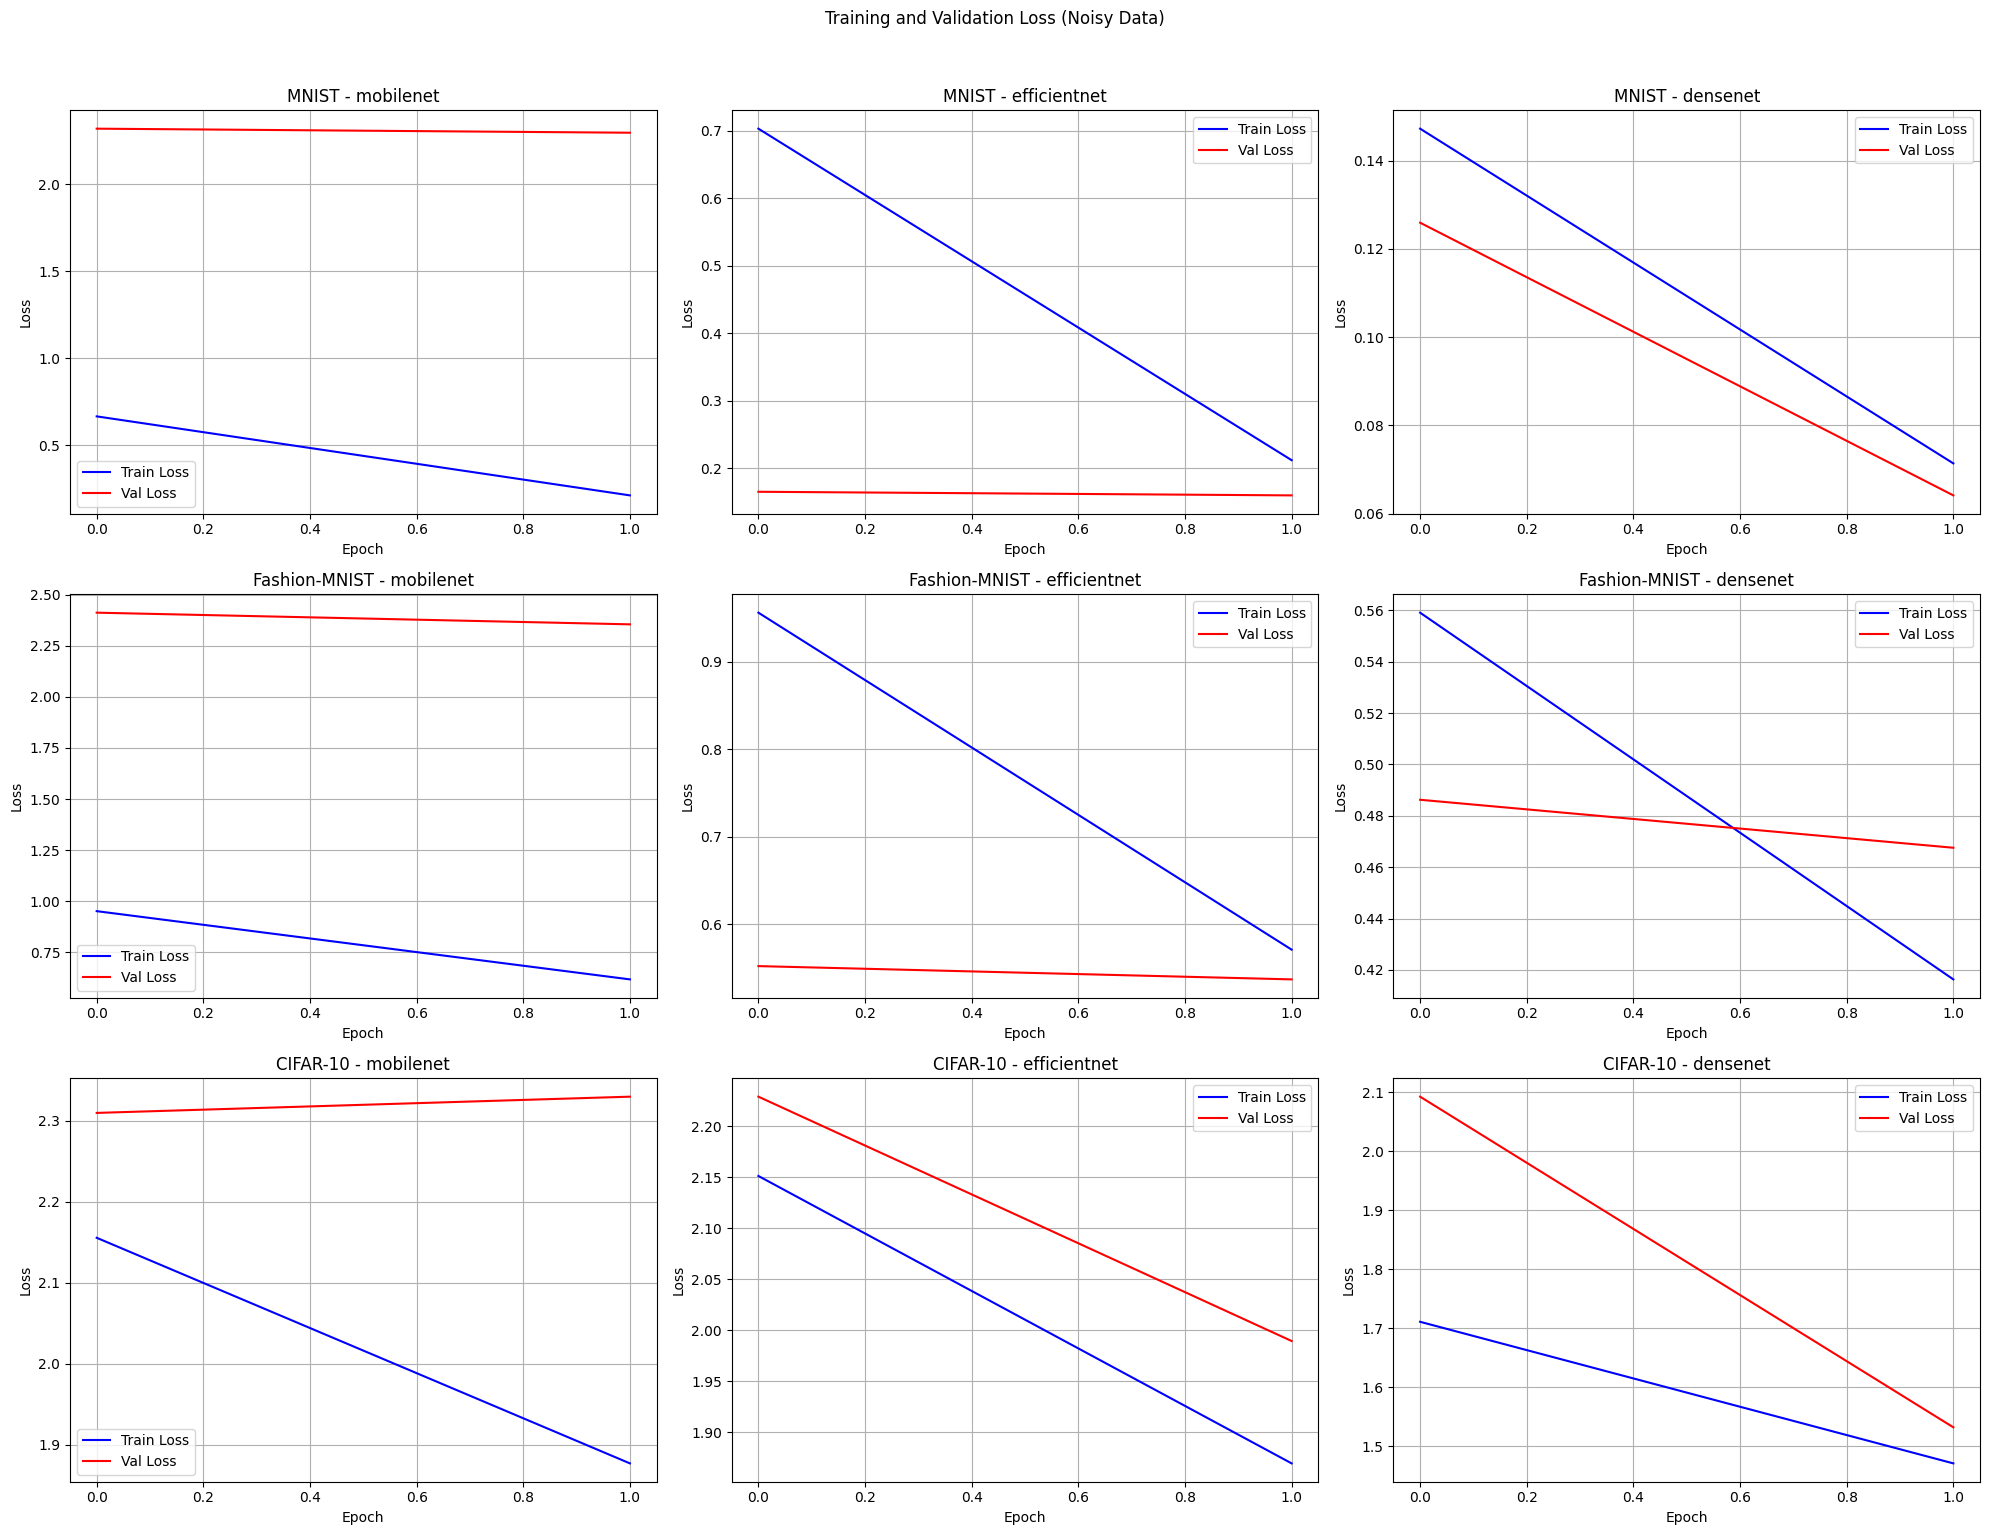

<ipython-input-1-7754e90fc748>:201: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Dataset', y='Accuracy', hue='Model',


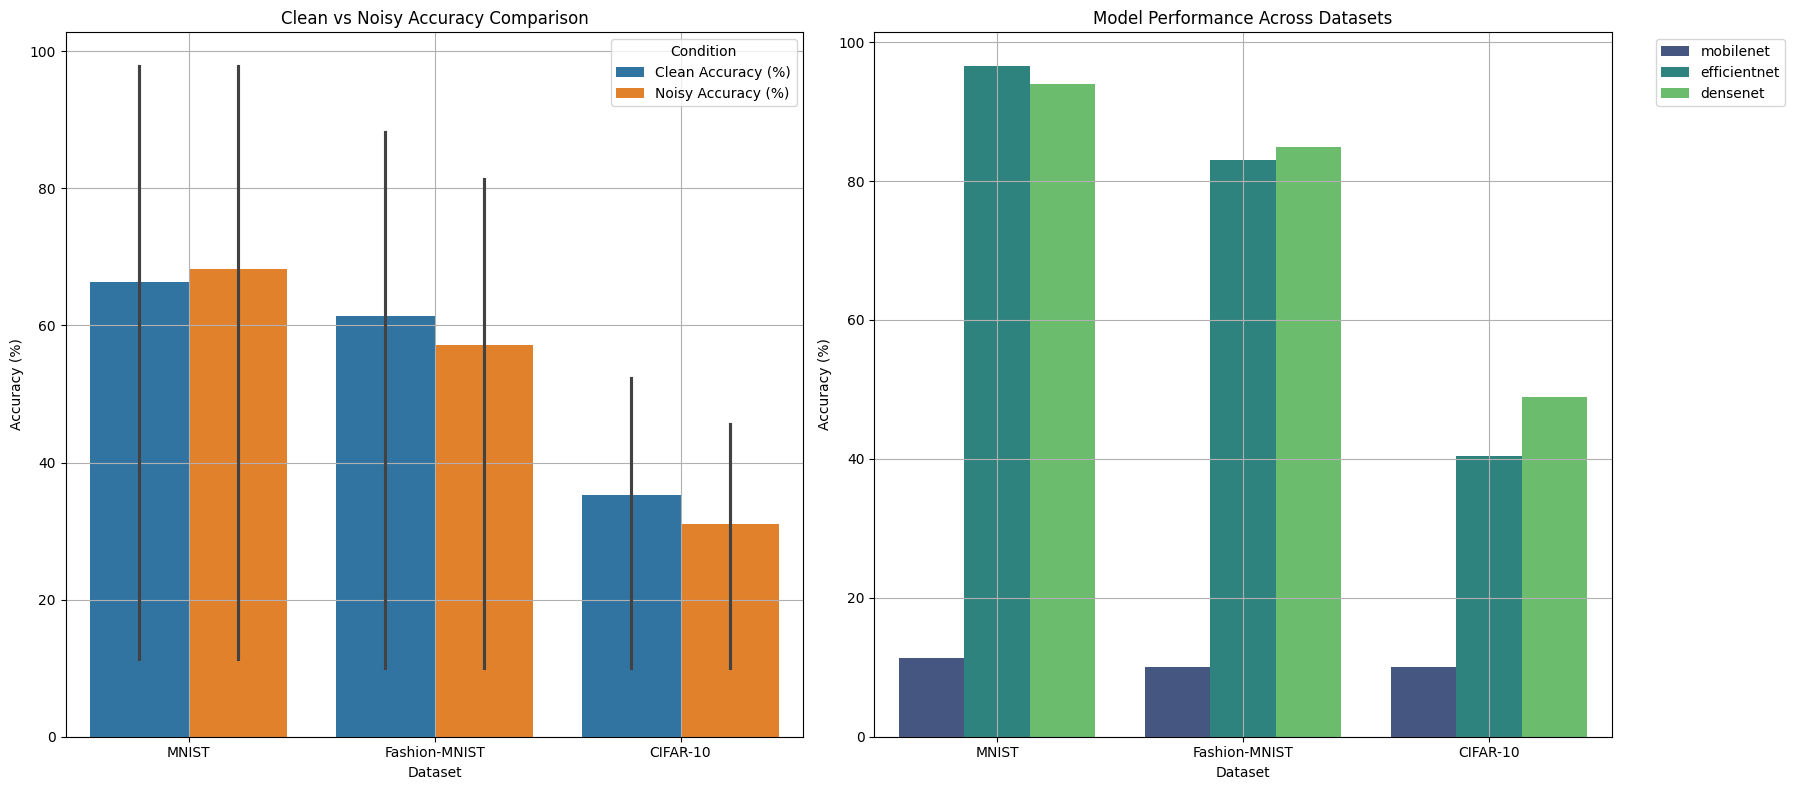

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import pandas as pd
from tensorflow.keras.datasets import mnist, fashion_mnist, cifar10
from tensorflow.keras import Input, Model
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, NASNetMobile, DenseNet121

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

def add_noise(data, noise_factor=0.3):
    noisy = data + noise_factor * np.random.normal(0.0, 1.0, data.shape)
    return np.clip(noisy, 0., 1.)

def build_model(input_shape, model_type='mobilenet'):
    inputs = Input(shape=input_shape)

    # Preprocessing for all pretrained models
    # Add channels if needed (for grayscale images)
    if input_shape[-1] == 1:
        x = tf.keras.layers.Concatenate()([inputs, inputs, inputs])
    else:
        x = inputs

    # Special handling for DenseNet which needs larger images
    if model_type == 'densenet' and input_shape[0] < 32:
        x = tf.keras.layers.UpSampling2D(size=(64//input_shape[0], 64//input_shape[0]))(x)
    # For other models
    elif input_shape[0] < 32:
        x = tf.keras.layers.UpSampling2D(size=(32//input_shape[0], 32//input_shape[0]))(x)

    if model_type == 'mobilenet':
        # MobileNetV2 - lightweight and efficient
        base = MobileNetV2(weights=None, include_top=False, input_tensor=x)
        x = tf.keras.layers.GlobalAveragePooling2D()(base.output)
        outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
    elif model_type == 'efficientnet':
        # EfficientNetB0 - smallest in EfficientNet family
        base = EfficientNetB0(weights=None, include_top=False, input_tensor=x)
        x = tf.keras.layers.GlobalAveragePooling2D()(base.output)
        outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
    elif model_type == 'densenet':
        # DenseNet121 - needs larger input size
        base = DenseNet121(weights=None, include_top=False, input_tensor=x)
        x = tf.keras.layers.GlobalAveragePooling2D()(base.output)
        outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def plot_all_sample_images(datasets):
    fig, axes = plt.subplots(len(datasets), 2, figsize=(10, 3*len(datasets)))
    for i, (dataset, name) in enumerate(datasets):
        (x_train, _), _ = dataset.load_data()
        x_train = x_train / 255.0
        if x_train.ndim == 3:
            x_train = np.expand_dims(x_train, -1)
        x_train_noisy = add_noise(x_train)

        axes[i, 0].imshow(x_train[0].squeeze(), cmap='gray')
        axes[i, 0].set_title(f'{name} - Clean')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(x_train_noisy[0].squeeze(), cmap='gray')
        axes[i, 1].set_title(f'{name} - Noisy')
        axes[i, 1].axis('off')
    plt.tight_layout()
    plt.show()

def combined_tsne_visualization(all_models, all_x_test, all_y_test, dataset_names, model_types, condition):
    plt.figure(figsize=(20, 15))
    for i, (models, x_test, y_test, dataset_name) in enumerate(zip(all_models, all_x_test, all_y_test, dataset_names)):
        for j, (model, model_type) in enumerate(zip(models, model_types)):
            if model is None:
                continue
            plt.subplot(len(dataset_names), len(model_types), i*len(model_types) + j + 1)

            # Get the last layer before the output layer
            layer_output = model.layers[-2].output
            intermediate_layer_model = Model(inputs=model.input, outputs=layer_output)
            features = intermediate_layer_model.predict(x_test[:1000])
            tsne = TSNE(n_components=2, random_state=42)
            reduced = tsne.fit_transform(features)

            scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=y_test[:1000], cmap='tab10', s=10)
            plt.title(f"{dataset_name} - {model_type}")
            if j == 0:
                plt.ylabel(condition)
            if i == 0 and j == len(model_types)-1:
                plt.colorbar(scatter, ax=plt.gca())
            plt.grid(True)
    plt.suptitle(f"t-SNE Feature Visualization ({condition} Data)", y=1.02)
    plt.tight_layout()
    plt.show()

def combined_conf_matrices(all_y_test, all_preds, dataset_names, model_types, condition):
    plt.figure(figsize=(20, 15))
    for i, (y_test, preds, dataset_name) in enumerate(zip(all_y_test, all_preds, dataset_names)):
        for j, (pred, model_type) in enumerate(zip(preds, model_types)):
            if pred is None:
                continue
            plt.subplot(len(dataset_names), len(model_types), i*len(model_types) + j + 1)
            cm = confusion_matrix(y_test, pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot(cmap='Blues', ax=plt.gca())
            plt.title(f"{dataset_name} - {model_type}")
            if j == 0:
                plt.ylabel(condition)
    plt.suptitle(f"Confusion Matrices ({condition} Data)", y=1.02)
    plt.tight_layout()
    plt.show()

def combined_roc_curves(all_models, all_x_test, all_y_test, dataset_names, model_types, condition):
    plt.figure(figsize=(20, 15))
    for i, (models, x_test, y_test, dataset_name) in enumerate(zip(all_models, all_x_test, all_y_test, dataset_names)):
        for j, (model, model_type) in enumerate(zip(models, model_types)):
            if model is None:
                continue
            plt.subplot(len(dataset_names), len(model_types), i*len(model_types) + j + 1)

            y_score = model.predict(x_test)
            y_bin = label_binarize(y_test, classes=list(range(10)))
            fpr, tpr, _ = roc_curve(y_bin.ravel(), y_score.ravel())
            roc_auc = auc(fpr, tpr)

            plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f"{dataset_name} - {model_type}")
            plt.legend(loc='lower right')
            if j == 0:
                plt.ylabel(condition)
            plt.grid(True)
    plt.suptitle(f"ROC Curves ({condition} Data)", y=1.02)
    plt.tight_layout()
    plt.show()

def combined_training_curves(all_histories, dataset_names, model_types, condition):
    # Create separate figures for accuracy and loss
    fig_acc, axes_acc = plt.subplots(len(dataset_names), len(model_types),
                         figsize=(20, 5*len(dataset_names)), squeeze=False)
    fig_loss, axes_loss = plt.subplots(len(dataset_names), len(model_types),
                          figsize=(20, 5*len(dataset_names)), squeeze=False)

    for i, (histories, dataset_name) in enumerate(zip(all_histories, dataset_names)):
        for j, (history, model_type) in enumerate(zip(histories, model_types)):
            if history is None:
                continue

            # Plot accuracy curves
            axes_acc[i,j].plot(history.history['accuracy'], label='Train Accuracy', color='blue')
            axes_acc[i,j].plot(history.history['val_accuracy'], label='Val Accuracy', color='red')
            axes_acc[i,j].set_title(f"{dataset_name} - {model_type}")
            axes_acc[i,j].set_xlabel('Epoch')
            axes_acc[i,j].set_ylabel('Accuracy')
            axes_acc[i,j].grid(True)
            axes_acc[i,j].legend()

            # Plot loss curves
            axes_loss[i,j].plot(history.history['loss'], label='Train Loss', color='blue')
            axes_loss[i,j].plot(history.history['val_loss'], label='Val Loss', color='red')
            axes_loss[i,j].set_title(f"{dataset_name} - {model_type}")
            axes_loss[i,j].set_xlabel('Epoch')
            axes_loss[i,j].set_ylabel('Loss')
            axes_loss[i,j].grid(True)
            axes_loss[i,j].legend()

    fig_acc.suptitle(f"Training and Validation Accuracy ({condition} Data)", y=1.02)
    fig_loss.suptitle(f"Training and Validation Loss ({condition} Data)", y=1.02)

    fig_acc.tight_layout()
    fig_loss.tight_layout()

    plt.show()

def plot_performance_summary(df):
    plt.figure(figsize=(18, 8))

    # Melt the dataframe for seaborn
    df_melted = df.melt(id_vars=['Dataset', 'Model'],
                        value_vars=['Clean Accuracy (%)', 'Noisy Accuracy (%)'],
                        var_name='Condition', value_name='Accuracy')

    # Clean vs Noisy comparison
    plt.subplot(1, 2, 1)
    sns.barplot(x='Dataset', y='Accuracy', hue='Condition', data=df_melted)
    plt.title("Clean vs Noisy Accuracy Comparison")
    plt.ylabel("Accuracy (%)")
    plt.grid(True)
    plt.xticks(rotation=0)

    # Model performance across datasets
    plt.subplot(1, 2, 2)
    sns.barplot(x='Dataset', y='Accuracy', hue='Model',
                data=df_melted, ci=None, palette='viridis')
    plt.title("Model Performance Across Datasets")
    plt.ylabel("Accuracy (%)")
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

def process_datasets(datasets):
    all_results = []
    all_clean_models = []
    all_noisy_models = []
    all_x_test = []
    all_y_test = []
    all_x_test_noisy = []
    all_clean_preds = []
    all_noisy_preds = []
    all_clean_histories = []
    all_noisy_histories = []
    dataset_names = []

    model_types = ['mobilenet', 'efficientnet', 'densenet']

    for loader, name in datasets:
        print(f"\nProcessing {name} dataset...")
        (x_train, y_train), (x_test, y_test) = loader.load_data()
        x_train, x_test = x_train / 255.0, x_test / 255.0

        if x_train.ndim == 3:
            x_train = np.expand_dims(x_train, -1)
            x_test = np.expand_dims(x_test, -1)

        input_shape = x_train.shape[1:]
        x_train_noisy = add_noise(x_train)
        x_test_noisy = add_noise(x_test)

        clean_models = []
        noisy_models = []
        clean_preds = []
        noisy_preds = []
        clean_histories = []
        noisy_histories = []

        for model_type in model_types:
            print(f"  Training {model_type} model...")
            try:
                # Clean Model
                model_clean = build_model(input_shape, model_type)
                history_clean = model_clean.fit(x_train, y_train, epochs=2,
                                              validation_data=(x_test, y_test), verbose=0)
                clean_pred = np.argmax(model_clean.predict(x_test), axis=1)

                # Noisy Model
                model_noisy = build_model(input_shape, model_type)
                history_noisy = model_noisy.fit(x_train_noisy, y_train, epochs=2,
                                              validation_data=(x_test_noisy, y_test), verbose=0)
                noisy_pred = np.argmax(model_noisy.predict(x_test_noisy), axis=1)

                # Evaluate
                clean_loss, clean_acc = model_clean.evaluate(x_test, y_test, verbose=0)
                noisy_loss, noisy_acc = model_noisy.evaluate(x_test_noisy, y_test, verbose=0)

                clean_models.append(model_clean)
                noisy_models.append(model_noisy)
                clean_preds.append(clean_pred)
                noisy_preds.append(noisy_pred)
                clean_histories.append(history_clean)
                noisy_histories.append(history_noisy)

                all_results.append({
                    'Dataset': name,
                    'Model': model_type,
                    'Clean Accuracy (%)': round(clean_acc * 100, 2),
                    'Noisy Accuracy (%)': round(noisy_acc * 100, 2)
                })

            except Exception as e:
                print(f"Error with {model_type} on {name}: {str(e)}")
                clean_models.append(None)
                noisy_models.append(None)
                clean_preds.append(None)
                noisy_preds.append(None)
                clean_histories.append(None)
                noisy_histories.append(None)
                all_results.append({
                    'Dataset': name,
                    'Model': model_type,
                    'Clean Accuracy (%)': None,
                    'Noisy Accuracy (%)': None
                })
                continue

        all_clean_models.append(clean_models)
        all_noisy_models.append(noisy_models)
        all_x_test.append(x_test)
        all_y_test.append(y_test)
        all_x_test_noisy.append(x_test_noisy)
        all_clean_preds.append(clean_preds)
        all_noisy_preds.append(noisy_preds)
        all_clean_histories.append(clean_histories)
        all_noisy_histories.append(noisy_histories)
        dataset_names.append(name)

    return (all_results, all_clean_models, all_noisy_models, all_x_test, all_y_test,
            all_x_test_noisy, all_clean_preds, all_noisy_preds, all_clean_histories,
            all_noisy_histories, dataset_names, model_types)

# Define datasets to process
datasets = [
    (mnist, "MNIST"),
    (fashion_mnist, "Fashion-MNIST"),
    (cifar10, "CIFAR-10")
]

# Plot sample images for all datasets
plot_all_sample_images(datasets)

# Process all datasets
(all_results, all_clean_models, all_noisy_models, all_x_test, all_y_test,
 all_x_test_noisy, all_clean_preds, all_noisy_preds, all_clean_histories,
 all_noisy_histories, dataset_names, model_types) = process_datasets(datasets)

# Create Dataframe
df = pd.DataFrame(all_results)
print("\nPerformance Summary:")
print(df)

# Combined visualizations
combined_tsne_visualization(all_clean_models, all_x_test, all_y_test, dataset_names, model_types, "Clean")
combined_tsne_visualization(all_noisy_models, all_x_test_noisy, all_y_test, dataset_names, model_types, "Noisy")

combined_conf_matrices(all_y_test, all_clean_preds, dataset_names, model_types, "Clean")
combined_conf_matrices(all_y_test, all_noisy_preds, dataset_names, model_types, "Noisy")

combined_roc_curves(all_clean_models, all_x_test, all_y_test, dataset_names, model_types, "Clean")
combined_roc_curves(all_noisy_models, all_x_test_noisy, all_y_test, dataset_names, model_types, "Noisy")

# Training curves visualization (updated version)
combined_training_curves(all_clean_histories, dataset_names, model_types, "Clean")
combined_training_curves(all_noisy_histories, dataset_names, model_types, "Noisy")

# Performance summary
plot_performance_summary(df)